In [1]:
import pickle
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["SCIPY_ARRAY_API"] = "1"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer


from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

from scipy.stats import shapiro
import scipy.stats as stats

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.inspection import permutation_importance
import shap

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV
from skopt import BayesSearchCV
import optuna
from sklearn.model_selection import cross_val_score


from utils.utils_graficos import avaliar_modelo
from utils.utils import tune_model

from sklearn.metrics import accuracy_score





# Leitura do arquivo

In [3]:
df = pd.read_csv('data/csv/ibm_hr_dataset_com_features.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 65 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Age                            1000000 non-null  int64  
 1   Attrition                      1000000 non-null  object 
 2   BusinessTravel                 1000000 non-null  object 
 3   DailyRate                      1000000 non-null  int64  
 4   Department                     1000000 non-null  object 
 5   DistanceFromHome               1000000 non-null  int64  
 6   Education                      1000000 non-null  int64  
 7   EducationField                 1000000 non-null  object 
 8   EmployeeCount                  1000000 non-null  int64  
 9   EmployeeNumber                 1000000 non-null  int64  
 10  EnvironmentSatisfaction        1000000 non-null  int64  
 11  Gender                         1000000 non-null  object 
 12  HourlyRate     

# Preparando dados modelagem

In [ ]:
cols_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df_processed = df.drop(columns=cols_to_drop)
label_encoder = LabelEncoder()
df_processed['Attrition'] = label_encoder.fit_transform(df_processed['Attrition'])
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 987231 to 551383
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            10000 non-null  int64  
 1   Attrition                      10000 non-null  int64  
 2   BusinessTravel                 10000 non-null  object 
 3   DailyRate                      10000 non-null  int64  
 4   Department                     10000 non-null  object 
 5   DistanceFromHome               10000 non-null  int64  
 6   Education                      10000 non-null  int64  
 7   EducationField                 10000 non-null  object 
 8   EnvironmentSatisfaction        10000 non-null  int64  
 9   Gender                         10000 non-null  object 
 10  HourlyRate                     10000 non-null  int64  
 11  JobInvolvement                 10000 non-null  int64  
 12  JobLevel                       10000 non-null

In [5]:
numeric_features = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
numeric_features.remove('Attrition')
print(f"Features numéricas: {numeric_features}")
print(f"Features categóricas: {categorical_features}")
print(f"Target: {df_processed['Attrition'].value_counts(normalize=True)}")

Features numéricas: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'IncomePerYear', 'TotalSatisfaction', 'PromotionRate', 'LongTimeNoPromotion', 'AgeStartedWorking', 'YearsInOtherCompanies', 'CompanyChangeRate', 'AnosCargoSemPromocao', 'CargoAlto_HorasExtras', 'ScoreEstab_Carreira', 'ScoreEstabilidadeFormat', 'Burnout', 'PercAnoEmpresaAtual', 'SalarioPorTempodeCasa', 'TreinamentosPorTempodeCasa', 'TempoCargoAtualPeloNivel', 'TempSemPromoPorTempComManager', 'TempGestAtualPorTempodeCasa', 'SalarioPorKm', 'SalarioPorNivelEdu', 'SalarioPorSatisf', 'PromotionsPerYear', 'CompaniesPerYear', 'YearsInRole

## Encoding variaveris categoricas
    Nada mais que é que pivotar ou algo semelhantes
[Fonte](https://www.alura.com.br/artigos/get-dummies-vs-onehotencoder-qual-metodo-escolher?srsltid=AfmBOooISDT9teazV3qXdrefLnP1CgVy_TucfgQCg913rquY2FxTeyXF)

In [6]:
one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    categorical_features),
    remainder='passthrough')
dados = one_hot_enc.fit_transform(df_processed)
df_encoded = pd.DataFrame(dados, columns=one_hot_enc.get_feature_names_out())

df_encoded.columns = df_encoded.columns.str.replace('onehotencoder__', '', regex=False)
df_encoded.columns = df_encoded.columns.str.replace('remainder__', '', regex=False)
df_encoded.columns = df_encoded.columns.str.strip('_')

df_encoded.head()

BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
0                        1.0                               0.0   
1                        0.0                               1.0   
2                        0.0                               0.0   
3                        0.0                               0.0   
4                        0.0                               0.0   

   BusinessTravel_Travel_Rarely  Department_Human Resources  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           1.0                         0.0   
3                           1.0                         0.0   
4                           1.0                         1.0   

   Department_Research & Development  Department_Sales  \
0                                0.0               1.0   
1                                0.0               1.0   
2                                0.0               1.0   
3                                1.0               0.0   
4                                0.0               0.0   

   EducationField_Human Resources  EducationField_Life Sciences  \
0                             1.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             1.0                           0.0   
4                             0.0                           1.0   

   EducationField_Marketing  EducationField_Medical  ...  SalarioPorSatisf  \
0                       0.0                     0.0  ...       2713.000000   
1                       1.0                     0.0  ...       2843.727273   
2                       1.0                     0.0  ...       3104.333333   
3                       0.0                     0.0  ...       4250.250000   
4                       0.0                     0.0  ...       3070.285714   

   PromotionsPerYear  CompaniesPerYear  YearsInRolePercCompany  \
0           0.250000          0.200000                0.750000   
1           0.125000          0.142857                0.190476   
2           0.142857          0.090909                0.454545   
3           0.166667          0.058824                0.777778   
4           1.000000          0.000000                0.000000   

   SatisfacaoGeral  SatisfacaoPeloNivel  EstavelNaEmpresa  \
0             2.50             0.833333               0.0   
1             3.25             1.083333               0.0   
2             2.75             1.375000               1.0   
3             2.75             0.916667               1.0   
4             2.50             1.250000               0.0   

   TempoComGestorProporcao  SalarioPorSatisfacaoGeral  SalarioAjustadoPorCargo  
0                 0.750000                2325.428571              2034.750000  
1                 0.000000                2453.411765              2606.750000  
2                 0.181818                2483.466667              3104.333333  
3                 0.000000                3022.400000              2833.500000  
4                 0.000000                2046.857143              2388.000000  

[5 rows x 80 columns]

## Salva como pickle o onohotenconder

In [16]:
with open('data/pickle/modelo_onehotenc.pkl', 'wb') as f:
    pickle.dump(one_hot_enc, f)

### usar o pickle 

In [17]:
modelo_onehotenc = pd.read_pickle('data/pickle/modelo_onehotenc.pkl')
dados = modelo_onehotenc.transform(df_processed)
df_encoded = pd.DataFrame(dados, columns=modelo_onehotenc.get_feature_names_out())
df_encoded.columns = df_encoded.columns.str.replace('onehotencoder__', '', regex=False)
df_encoded.columns = df_encoded.columns.str.replace('remainder__', '', regex=False)
df_encoded.columns = df_encoded.columns.str.strip('_')

df_encoded

BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
0                           1.0                               0.0   
1                           0.0                               1.0   
2                           0.0                               0.0   
3                           0.0                               0.0   
4                           0.0                               0.0   
...                         ...                               ...   
9995                        0.0                               1.0   
9996                        1.0                               0.0   
9997                        0.0                               0.0   
9998                        0.0                               1.0   
9999                        0.0                               0.0   

      BusinessTravel_Travel_Rarely  Department_Human Resources  \
0                              0.0                         0.0   
1                              0.0                         0.0   
2                              1.0                         0.0   
3                              1.0                         0.0   
4                              1.0                         1.0   
...                            ...                         ...   
9995                           0.0                         0.0   
9996                           0.0                         0.0   
9997                           1.0                         0.0   
9998                           0.0                         1.0   
9999                           1.0                         0.0   

      Department_Research & Development  Department_Sales  \
0                                   0.0               1.0   
1                                   0.0               1.0   
2                                   0.0               1.0   
3                                   1.0               0.0   
4                                   0.0               0.0   
...                                 ...               ...   
9995                                0.0               1.0   
9996                                1.0               0.0   
9997                                0.0               1.0   
9998                                0.0               0.0   
9999                                0.0               1.0   

      EducationField_Human Resources  EducationField_Life Sciences  \
0                                1.0                           0.0   
1                                0.0                           0.0   
2                                0.0                           0.0   
3                                1.0                           0.0   
4                                0.0                           1.0   
...                              ...                           ...   
9995                             0.0                           0.0   
9996                             0.0                           1.0   
9997                             0.0                           0.0   
9998                             0.0                           1.0   
9999                             0.0                           0.0   

      EducationField_Marketing  EducationField_Medical  ...  SalarioPorSatisf  \
0                          0.0                     0.0  ...       2713.000000   
1                          1.0                     0.0  ...       2843.727273   
2                          1.0                     0.0  ...       3104.333333   
3                          0.0                     0.0  ...       4250.250000   
4                          0.0                     0.0  ...       3070.285714   
...                        ...                     ...  ...               ...   
9995                       0.0                     1.0  ...       3336.000000   
9996                       0.0                     0.0  ...       5670.000000   
9997                       0.0                     0.0  ...       3313.875000   


## Divisão de treino e teste

In [7]:
X = df_encoded.drop('Attrition', axis=1) #features
y = df_encoded['Attrition'] #target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #usando o stratify para manter a proporção de classes no conjunto de teste devido ao desbalanceamento
print(f"\nTamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Total de features: {X_train.shape[1]}")
print(f"Proporção Attrition no treino: {y_train.mean():.2%}")
print(f"Proporção Attrition no teste: {y_test.mean():.2%}")


Tamanho do conjunto de treino: (8000, 79)
Tamanho do conjunto de teste: (2000, 79)
Total de features: 79
Proporção Attrition no treino: 17.95%
Proporção Attrition no teste: 17.95%


### Oversampling

#### SMOTE
    Cria exemplos sintéticos da classe minoritária combinando exemplos reais.

In [8]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train,)
y_train.value_counts(), y_train_over.value_counts()

(Attrition
 0.0    6564
 1.0    1436
 Name: count, dtype: int64,
 Attrition
 1.0    6564
 0.0    6564
 Name: count, dtype: int64)

In [9]:
print(f"Proporção Attrition no treino Over SMOTE: {y_train_over.mean():.2%}")
print(f"Proporção Attrition no teste: {y_test.mean():.2%}")

Proporção Attrition no treino Over SMOTE: 50.00%
Proporção Attrition no teste: 17.95%


#### ADASYN
    Parecido com SMOTE, mas gera mais exemplos em áreas de difícil classificação.

In [10]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
y_train.value_counts(),
y_train_adasyn.value_counts()

Attrition
1.0    6760
0.0    6564
Name: count, dtype: int64

In [11]:
print(f"Proporção Attrition no treino Over ADASYN: {y_train_adasyn.mean():.2%}")
print(f"Proporção Attrition no teste: {y_test.mean():.2%}")

Proporção Attrition no treino Over ADASYN: 50.74%
Proporção Attrition no teste: 17.95%


### Undersampling

#### RandomUnderSampler
    Remove exemplos da classe majoritária.

In [12]:
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print(y_train.value_counts(), y_train_under.value_counts())

Attrition
0.0    6564
1.0    1436
Name: count, dtype: int64 Attrition
0.0    1436
1.0    1436
Name: count, dtype: int64


In [13]:
print(f"Proporção Attrition no treino under: {y_train_under.mean():.2%}")
print(f"Proporção Attrition no teste: {y_test.mean():.2%}")

Proporção Attrition no treino under: 50.00%
Proporção Attrition no teste: 17.95%


## Feature selection

### Baixa variancia

In [14]:
selector = VarianceThreshold(threshold=0.05)
X_train_var = selector.fit_transform(X_train)
features_var = X_train.columns[selector.get_support()]# Recupera os nomes das features mantidas
print("Top features após VarianceThreshold:")
print(features_var[:20])

Top features após VarianceThreshold:
Index(['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive'],
      dtype='object')


In [15]:
len(features_var)

74

### Correlação
    Faz uma correlação entre elas e tira as colunas que são mais reduntantes

In [16]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper.columns if any(upper[column] > 0.8)]
X_train_corr = X_train.drop(drop_cols, axis=1)
print("Features após remoção de correlação alta:")
print(X_train_corr.columns)

Features após remoção de correlação alta:
Index(['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'OverTime_No', 'Age', 'DailyRate',
       'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyRate', 'NumCompaniesWorked', 'Perce

In [17]:
len(X_train_corr.columns)
len(X_train.columns)
print(len(X_train.columns) - len(X_train_corr.columns))

14


### SelectKBest
    Usa teste estatístico (ANOVA, chi2) para escolher as variáveis mais relacionadas à target.

In [18]:
selector = SelectKBest(score_func=f_classif, k=20)
X_train_best = selector.fit_transform(X_train, y_train)

features_best = X_train.columns[selector.get_support()]
print(features_best)

Index(['OverTime_No', 'OverTime_Yes', 'Age', 'Education',
       'EnvironmentSatisfaction', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'StockOptionLevel', 'TotalWorkingYears',
       'WorkLifeBalance', 'YearsAtCompany', 'TotalSatisfaction',
       'PromotionRate', 'AnosCargoSemPromocao', 'Burnout', 'SalarioPorKm',
       'SatisfacaoGeral', 'SatisfacaoPeloNivel', 'SalarioPorSatisfacaoGeral'],
      dtype='object')


In [19]:
len(features_best)

20

### Features em comum entre todos os features selections

In [20]:
commun_features = set(features_best) & set(features_var) & set(X_train_corr.columns)

print(f'features em comum em todos os features selections: \
      \n {commun_features}')


features em comum em todos os features selections:       
 {'Education', 'YearsAtCompany', 'TotalSatisfaction', 'StockOptionLevel', 'EnvironmentSatisfaction', 'PromotionRate', 'JobLevel', 'SalarioPorKm', 'WorkLifeBalance', 'OverTime_No', 'Age', 'JobSatisfaction', 'AnosCargoSemPromocao'}


## Normalização das features

### Analise de normalidade das features

#### Shapiro
* Teste estatístico para verificar se os dados vêm de uma distribuição normal.
* Retorna um p-value.
    * Se p < 0.05: rejeita normalidade (dados não são normais).
    * Se p ≥ 0.05: não rejeita normalidade (dados podem ser normais).

In [21]:
resultados = []
for col in numeric_features:
    stat, p = shapiro(df[col].dropna())
    normal = 'Sim' if p >= 0.05 else 'Não'
    resultados.append({'feature': col, 'p_value': p, 'normal': normal})

df_normalidade = pd.DataFrame(resultados)
df_normalidade

feature        p_value normal
0                             Age   2.403655e-81    Não
1                       DailyRate  3.127623e-129    Não
2                DistanceFromHome  3.188439e-169    Não
3                       Education  8.575938e-153    Não
4         EnvironmentSatisfaction  3.633222e-167    Não
5                      HourlyRate  1.233381e-129    Não
6                  JobInvolvement  4.930583e-173    Não
7                        JobLevel  4.025323e-172    Não
8                 JobSatisfaction  3.172885e-167    Não
9                   MonthlyIncome   6.087930e-59    Não
10                    MonthlyRate  3.998952e-129    Não
11             NumCompaniesWorked  1.011441e-147    Não
12              PercentSalaryHike  1.037112e-154    Não
13              PerformanceRating  1.566976e-215    Não
14       RelationshipSatisfaction  3.499018e-167    Não
15               StockOptionLevel  3.187348e-166    Não
16              TotalWorkingYears   3.322650e-93    Não
17          TrainingTimesLastYear  8.534144e-134    Não
18                WorkLifeBalance  6.678801e-164    Não
19                 YearsAtCompany  1.309056e-130    Não
20             YearsInCurrentRole  1.020689e-145    Não
21        YearsSinceLastPromotion  8.589585e-150    Não
22           YearsWithCurrManager  1.196876e-158    Não
23                  IncomePerYear  5.651278e-217    Não
24              TotalSatisfaction  1.447766e-125    Não
25                  PromotionRate  1.049478e-145    Não
26            LongTimeNoPromotion  8.301273e-216    Não
27              AgeStartedWorking  6.379612e-159    Não
28          YearsInOtherCompanies  2.446242e-157    Não
29              CompanyChangeRate  3.838754e-169    Não
30           AnosCargoSemPromocao  4.150837e-188    Não
31          CargoAlto_HorasExtras  1.260636e-225    Não
32            ScoreEstab_Carreira  1.506686e-136    Não
33        ScoreEstabilidadeFormat  1.866411e-157    Não
34                        Burnout  6.595825e-235    Não
35            PercAnoEmpresaAtual  4.532432e-144    Não
36          SalarioPorTempodeCasa  1.786338e-197    Não
37     TreinamentosPorTempodeCasa  7.900933e-201    Não
38       TempoCargoAtualPeloNivel  6.592790e-148    Não
39  TempSemPromoPorTempComManager  3.125347e-183    Não
40    TempGestAtualPorTempodeCasa  3.770769e-159    Não
41                   SalarioPorKm  5.752116e-182    Não
42             SalarioPorNivelEdu  5.458386e-179    Não
43               SalarioPorSatisf  1.530923e-137    Não
44              PromotionsPerYear  1.208475e-183    Não
45               CompaniesPerYear  3.838754e-169    Não
46         YearsInRolePercCompany  5.467264e-146    Não
47                SatisfacaoGeral  2.432870e-118    Não
48            SatisfacaoPeloNivel  2.086317e-165    Não
49               EstavelNaEmpresa  3.357225e-209    Não
50        TempoComGestorProporcao  3.770769e-159    Não
51      SalarioPorSatisfacaoGeral   1.206915e-85    Não
52        SalarioAjustadoPorCargo   2.090900e-71    Não

In [22]:
df_normalidade['normal'].value_counts(normalize=True)

normal
Não    1.0
Name: proportion, dtype: float64

### Sobre os graficos
* KDE (Kernel Density Estimation)
     * Linha suave que estima a “densidade” da distribuição dos dados
     * Um KDE em formato de sino sugere normalidade.
     * Serve para visualizar “degraus”, caudas, etc. com mais clareza que o histograma.
* Q-Q Plot (Quantile-Quantile Plot)
     * Gráfico que compara os quantis dos seus dados com os quantis esperados de uma normal.
     * Se os pontos seguem a linha reta: distribuição normal.
     * Se há desvios sistemáticos: caudas pesadas, assimetria, ou não normal.
     * Ótimo para ver se só as extremidades (“caudas”) quebram a normalidade.


Age: p-value = 0.00000 (Não normal)
Age: p-value = 0.00000 (Não normal)


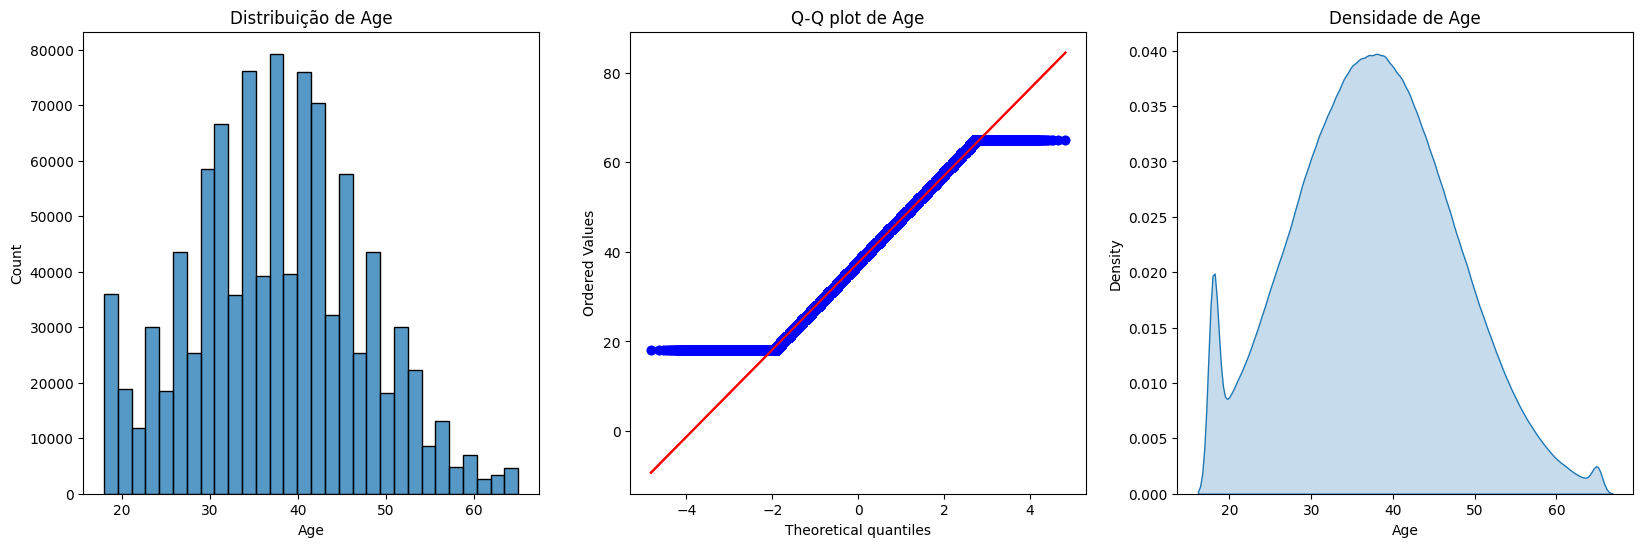

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
col = 'Age'

sns.histplot(df[col].dropna(), bins=30, ax=axes[0])
axes[0].set_title(f'Distribuição de {col}')

stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
axes[1].set_title(f'Q-Q plot de {col}')


stat, p = shapiro(df[col].dropna())
print(f"{col}: p-value = {p:.5f} {'(Normal)' if p >= 0.05 else '(Não normal)'}")


stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
axes[1].set_title(f'Q-Q plot de {col}')


stat, p = shapiro(df[col].dropna())
print(f"{col}: p-value = {p:.5f} {'(Normal)' if p >= 0.05 else '(Não normal)'}")

sns.kdeplot(df[col].dropna(), shade=True, ax=axes[2])
axes[2].set_title(f'Densidade de {col}')
plt.show()


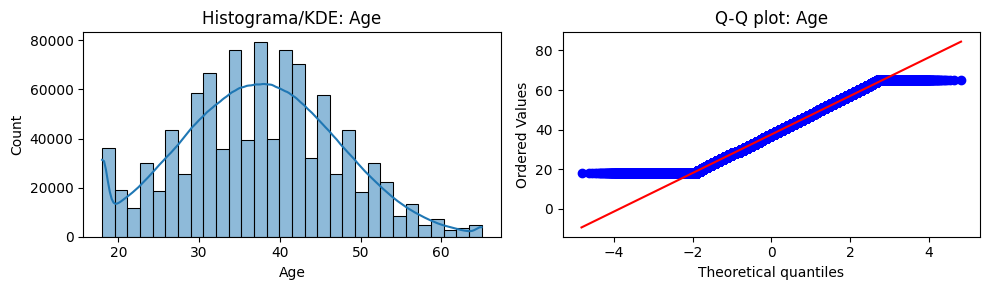

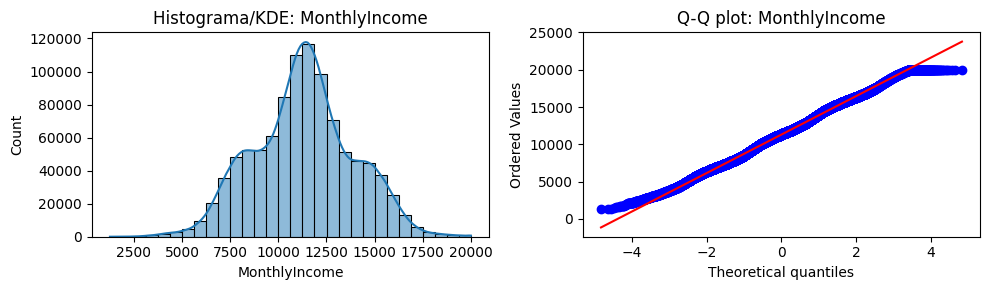

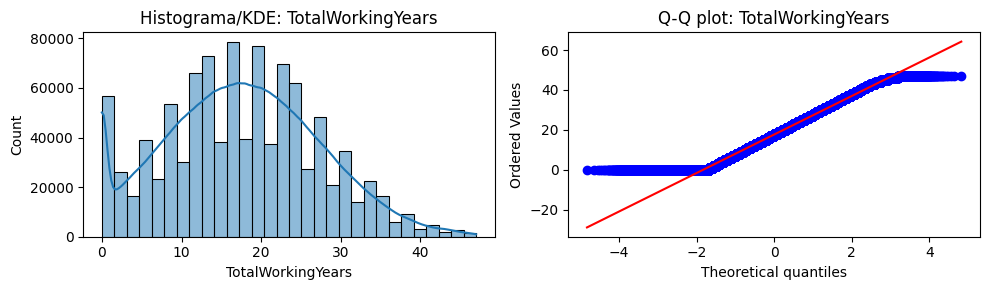

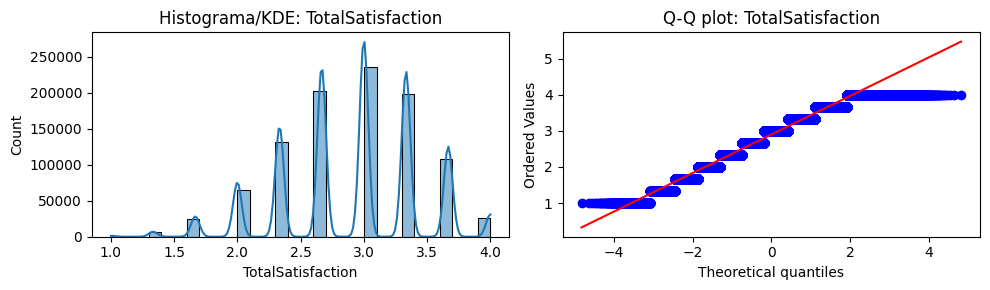

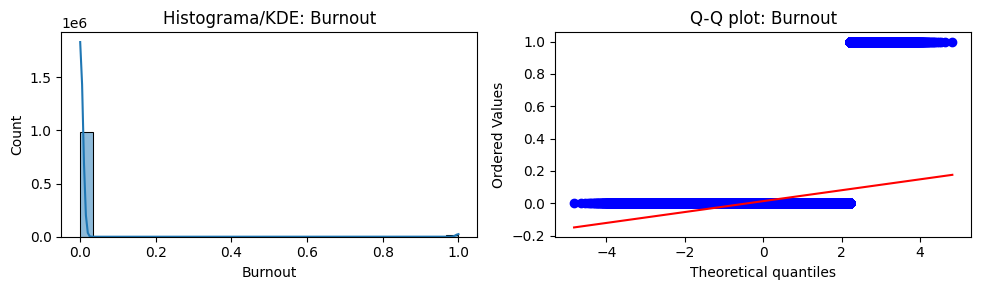

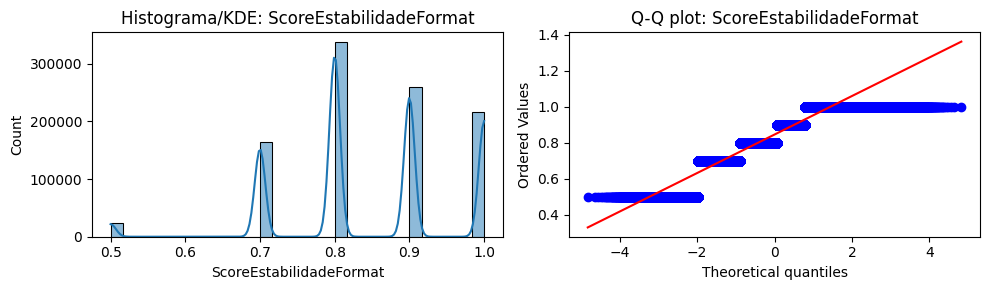

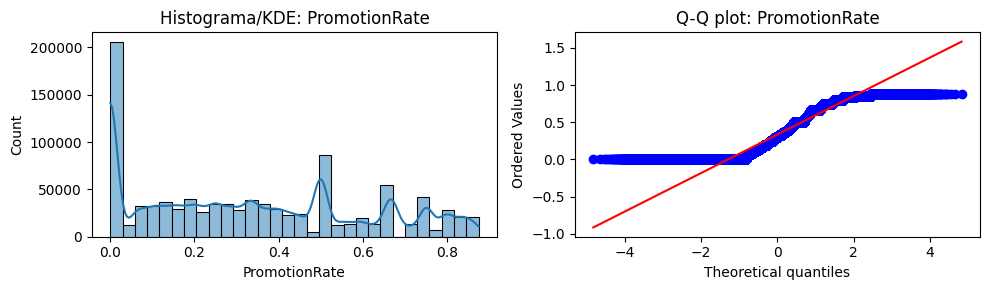

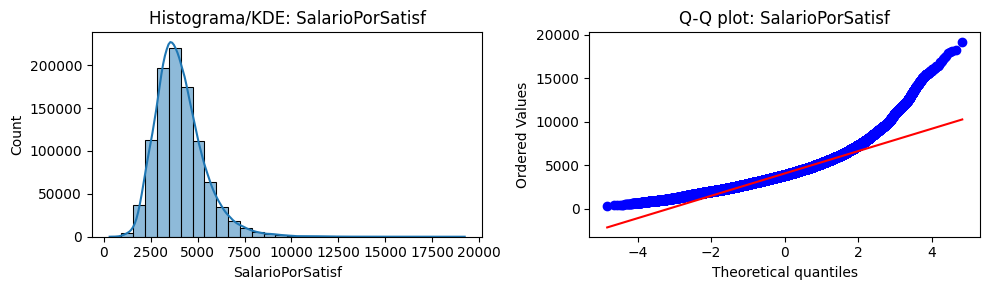

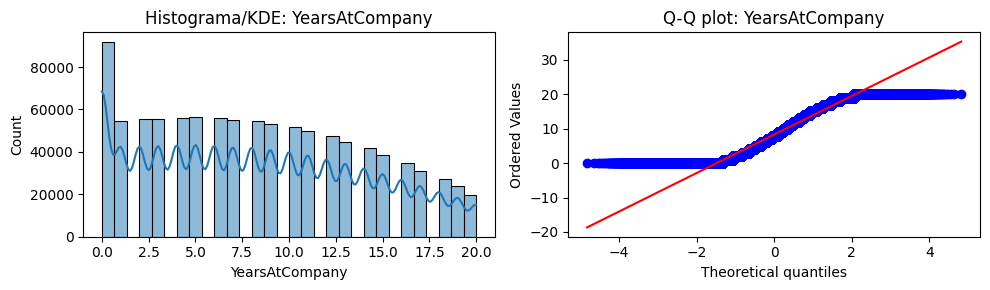

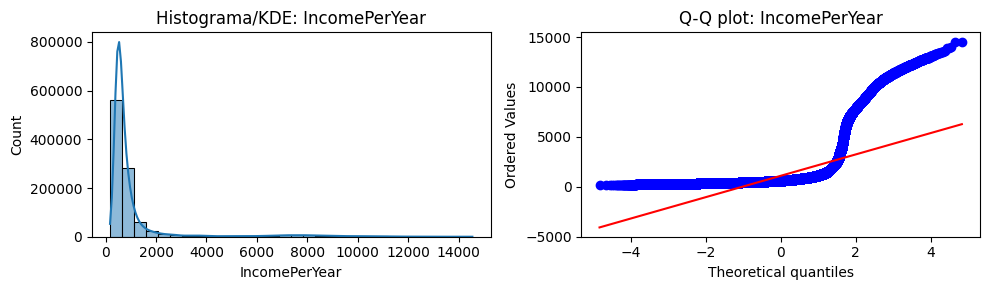

In [24]:
features_teste = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'TotalSatisfaction', 'Burnout', 'ScoreEstabilidadeFormat', 'PromotionRate', 'SalarioPorSatisf', 'YearsAtCompany', 'IncomePerYear'] 

for col in features_teste:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Histograma/KDE: {col}')
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'Q-Q plot: {col}')
    plt.tight_layout()
    plt.show()

### StandardScaler
    Normalmente para dados que são normal curva de sino (guassiana) ou que são < 0.05

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_over)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.34606052, -0.54362613,  0.70153333, ..., -1.09495904,
        -0.05403649, -1.12991681],
       [-0.34606052,  2.10430233, -1.62881872, ..., -1.09495904,
         2.31558649,  0.50937889],
       [-0.34606052, -0.54362613,  0.70153333, ..., -1.09495904,
         0.85836894, -0.63279071],
       ...,
       [-0.34606052, -0.54362613,  0.70153333, ...,  0.01387555,
        -1.4821164 , -1.45490835],
       [-0.34606052, -0.54362613,  0.70153333, ..., -1.09495904,
        -0.16478304, -0.40460129],
       [-0.34606052,  0.65055387, -0.34942399, ...,  0.17127507,
         0.90988058,  0.81315722]], shape=(13128, 79))

### Normalizer
    Para dados não é normal
    Normalize age reescalando os dados por exemplos/linhas e não por colunas, ou seja, o Normalizer levará em contas os atributos idade, salário e bonus e reescalar os valores com base nesses três valores

In [26]:
X_train_normalize = Normalizer().fit_transform(X_train_over)
X_test_normalize = Normalizer().fit_transform(X_test)
X_train_normalize

array([[0.00000000e+00, 0.00000000e+00, 3.56195232e-05, ...,
        0.00000000e+00, 1.01057676e-01, 8.84254664e-02],
       [0.00000000e+00, 4.83810065e-05, 0.00000000e+00, ...,
        0.00000000e+00, 2.22269787e-01, 1.44475362e-01],
       [0.00000000e+00, 0.00000000e+00, 6.92517882e-05, ...,
        0.00000000e+00, 2.43327700e-01, 1.82495775e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 6.26104831e-05, ...,
        1.66791158e-05, 1.11337746e-01, 1.49178311e-01],
       [0.00000000e+00, 0.00000000e+00, 4.02627367e-05, ...,
        0.00000000e+00, 1.10924939e-01, 1.08925393e-01],
       [0.00000000e+00, 2.29207095e-05, 2.79027838e-05, ...,
        1.54610051e-05, 1.80517991e-01, 1.56513020e-01]],
      shape=(13128, 79))

### MinMax Scaler
    para dados não normais
    o cálculo da reescala é feito de forma independente entre cada coluna, de tal forma que a nova escala se dará entre 0 e 1 (ou -1 e 1 se houver valores negativos no dataset)
    valor = ( valor — Coluna.min) / (Coluna.max — Coluna.min)

In [45]:
X_train_minmax = MinMaxScaler().fit_transform(X_train)
X_test_minmax = MinMaxScaler().fit_transform(X_test)
X_train_minmax

array([[0.        , 0.        , 1.        , ..., 0.        , 0.36781538,
        0.43441301],
       [0.        , 1.        , 0.        , ..., 0.        , 0.65873145,
        0.58206068],
       [0.        , 0.        , 1.        , ..., 0.        , 0.47983041,
        0.47918804],
       ...,
       [0.        , 0.        , 1.        , ..., 0.0952381 , 0.29467879,
        0.52591724],
       [0.        , 0.        , 1.        , ..., 0.76190476, 0.33470606,
        0.52806683],
       [0.        , 1.        , 0.        , ..., 0.        , 0.31234172,
        0.57767844]], shape=(8000, 79))

In [ ]:
X_train_minmax_over = MinMaxScaler().fit_transform(X_train_over)
X_test_minmax_over = MinMaxScaler().fit_transform(X_test)
X_train_minmax_over

array([[0.        , 0.        , 1.        , ..., 0.        , 0.36781538,
        0.43441301],
       [0.        , 1.        , 0.        , ..., 0.        , 0.65873145,
        0.58206068],
       [0.        , 0.        , 1.        , ..., 0.        , 0.47983041,
        0.47918804],
       ...,
       [0.        , 0.        , 1.        , ..., 0.30445136, 0.19249154,
        0.40514176],
       [0.        , 0.        , 1.        , ..., 0.        , 0.35421914,
        0.49974055],
       [0.        , 0.4509865 , 0.5490135 , ..., 0.34766835, 0.48615444,
        0.60942131]], shape=(13128, 79))

## Feature importance

### RandomForestClassifier

### com features sclar

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42)
rf_quick.fit(X_train_scaled, y_train_over)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False).head(20)

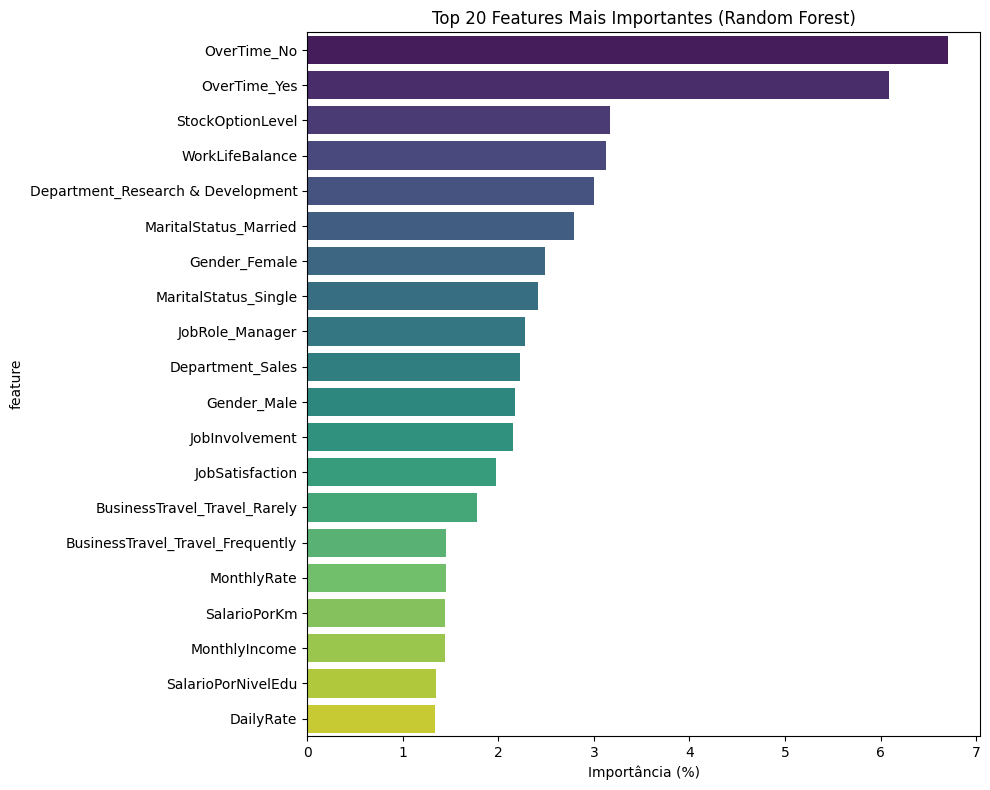

In [29]:
plt.figure(figsize=(10, 8))
feature_importance['importance_pct'] = feature_importance['importance'] * 100
sns.barplot(data=feature_importance, x='importance_pct', y='feature', palette='viridis')
plt.title('Top 20 Features Mais Importantes (Random Forest)')
plt.xlabel('Importância (%)')
plt.tight_layout()
plt.show()

### COm features normalizade

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42)
rf_quick.fit(X_train_normalize, y_train_over)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False).head(20)

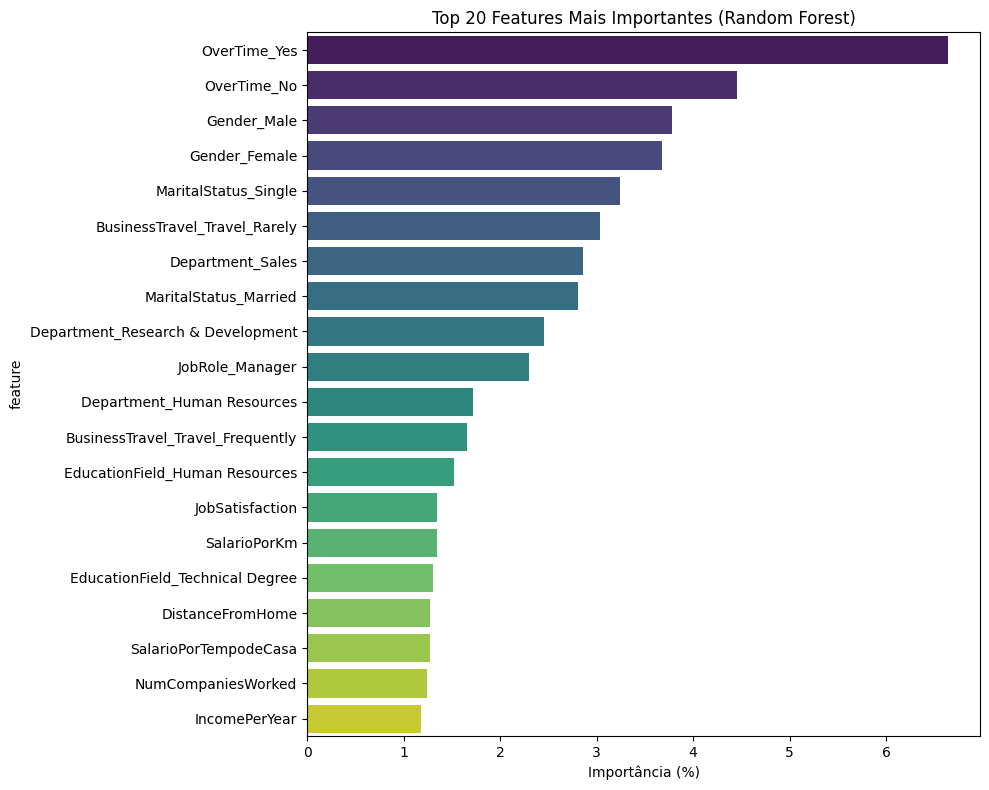

In [31]:
plt.figure(figsize=(10, 8))
feature_importance['importance_pct'] = feature_importance['importance'] * 100
sns.barplot(data=feature_importance, x='importance_pct', y='feature', palette='viridis')
plt.title('Top 20 Features Mais Importantes (Random Forest)')
plt.xlabel('Importância (%)')
plt.tight_layout()
plt.show()

### Com features minMax

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42)
rf_quick.fit(X_train_minmax, y_train_over)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False).head(20)

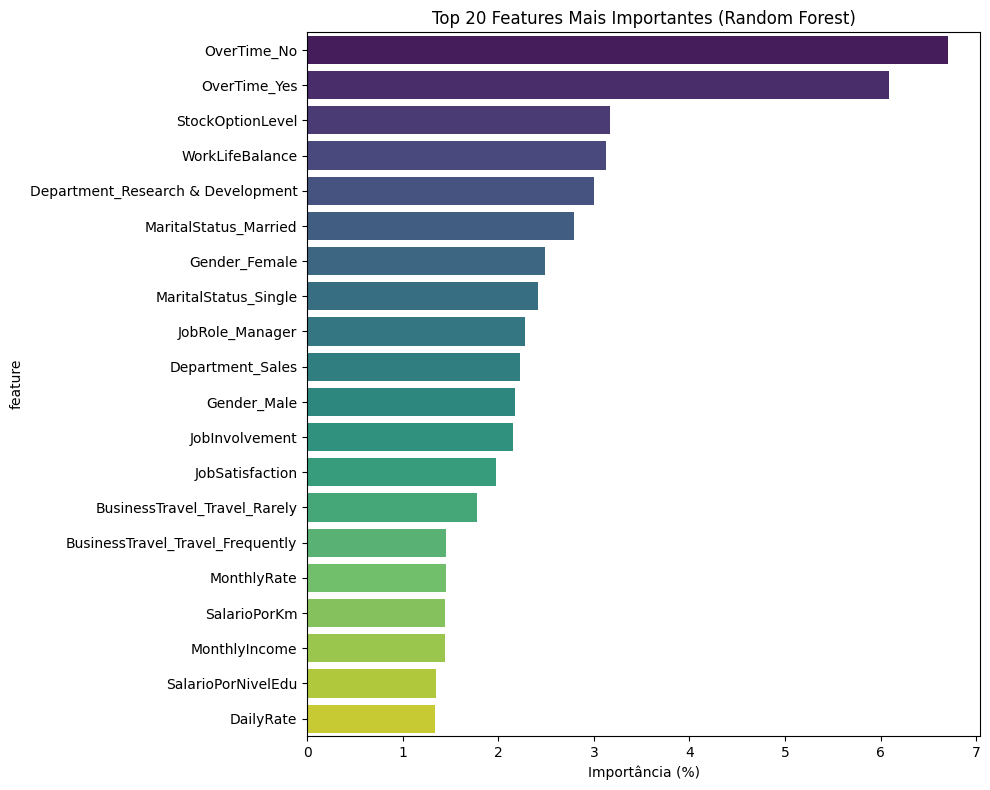

In [33]:
plt.figure(figsize=(10, 8))
feature_importance['importance_pct'] = feature_importance['importance'] * 100
sns.barplot(data=feature_importance, x='importance_pct', y='feature', palette='viridis')
plt.title('Top 20 Features Mais Importantes (Random Forest)')
plt.xlabel('Importância (%)')
plt.tight_layout()
plt.show()

### Permutation importance
    Mede quanto a métrica do modelo cai quando uma feature é embaralhada. pois considera até correlações entre features.

In [34]:

result = permutation_importance(rf_quick, X_test_minmax, y_test, n_repeats=10, random_state=42)
imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': result.importances_mean}).sort_values('importance', ascending=False)
imp_df

feature  importance
25                       OverTime_Yes     0.00200
13                        Gender_Male     0.00105
5                    Department_Sales     0.00085
24                        OverTime_No     0.00050
1    BusinessTravel_Travel_Frequently     0.00035
..                                ...         ...
49                      IncomePerYear    -0.00165
61                PercAnoEmpresaAtual    -0.00170
68                 SalarioPorNivelEdu    -0.00175
27                          DailyRate    -0.00175
4   Department_Research & Development    -0.00215

[79 rows x 2 columns]

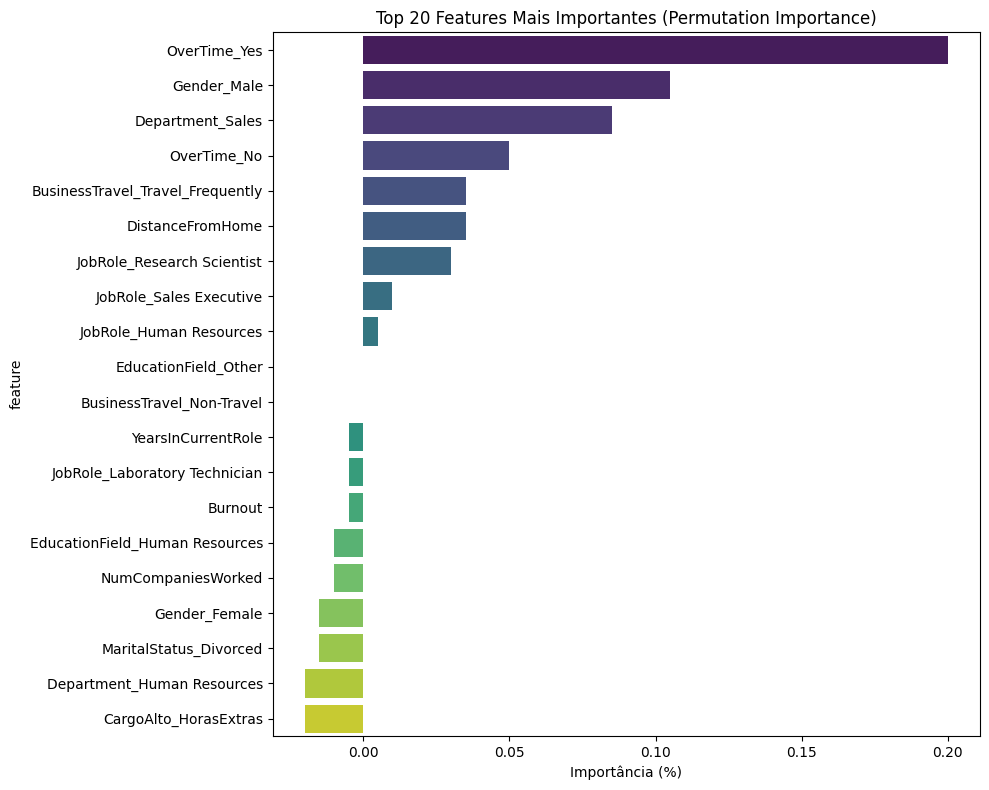

In [35]:
plt.figure(figsize=(10, 8))
imp_df['importance_pct'] = imp_df['importance'] * 100
sns.barplot(data=imp_df.head(20), x='importance_pct', y='feature', palette='viridis')
plt.title('Top 20 Features Mais Importantes (Permutation Importance)')
plt.xlabel('Importância (%)')
plt.tight_layout()
plt.show()

### SHAP

In [36]:
explainer = shap.TreeExplainer(rf_quick)
amostra = 1_000
X_sample = X_test[:amostra]
shap_values = explainer.shap_values(X_sample)
print(np.shape(shap_values))

(1000, 79, 2)


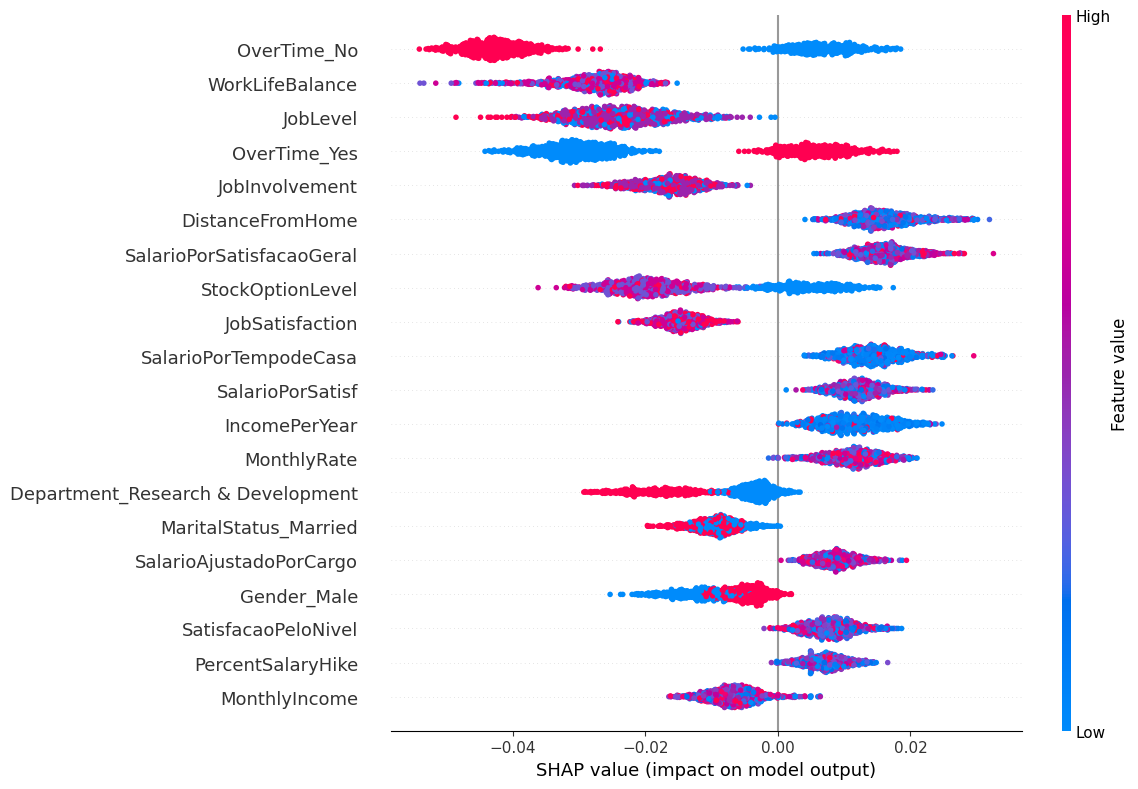

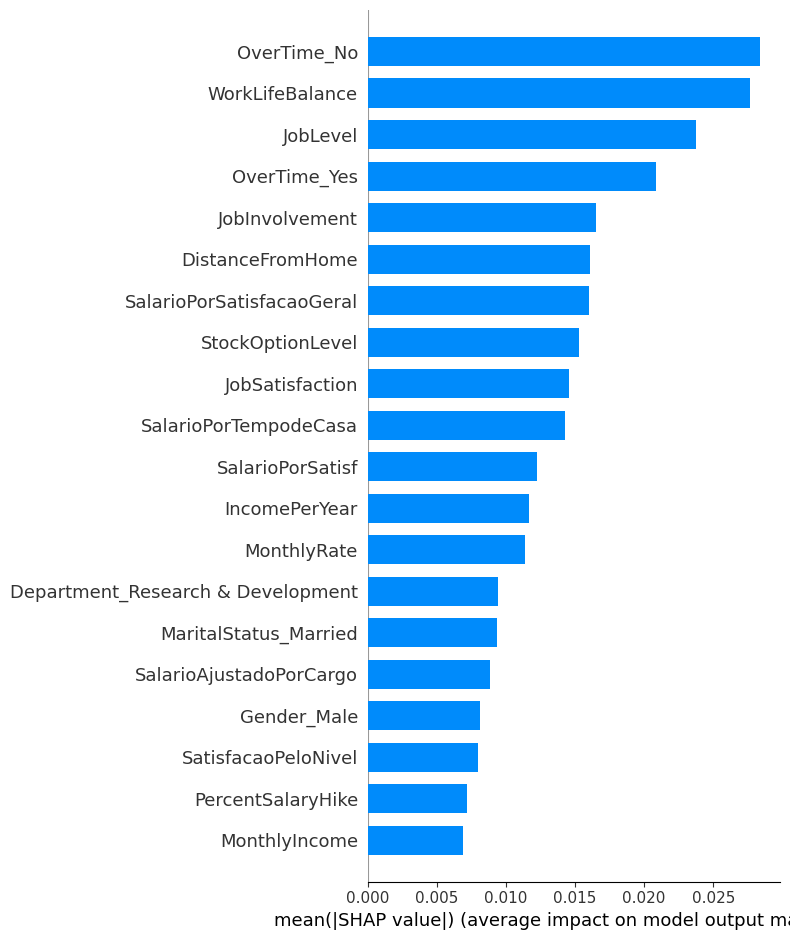

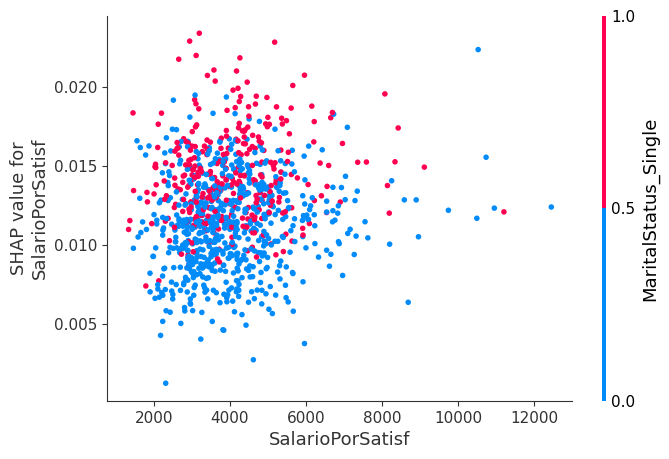

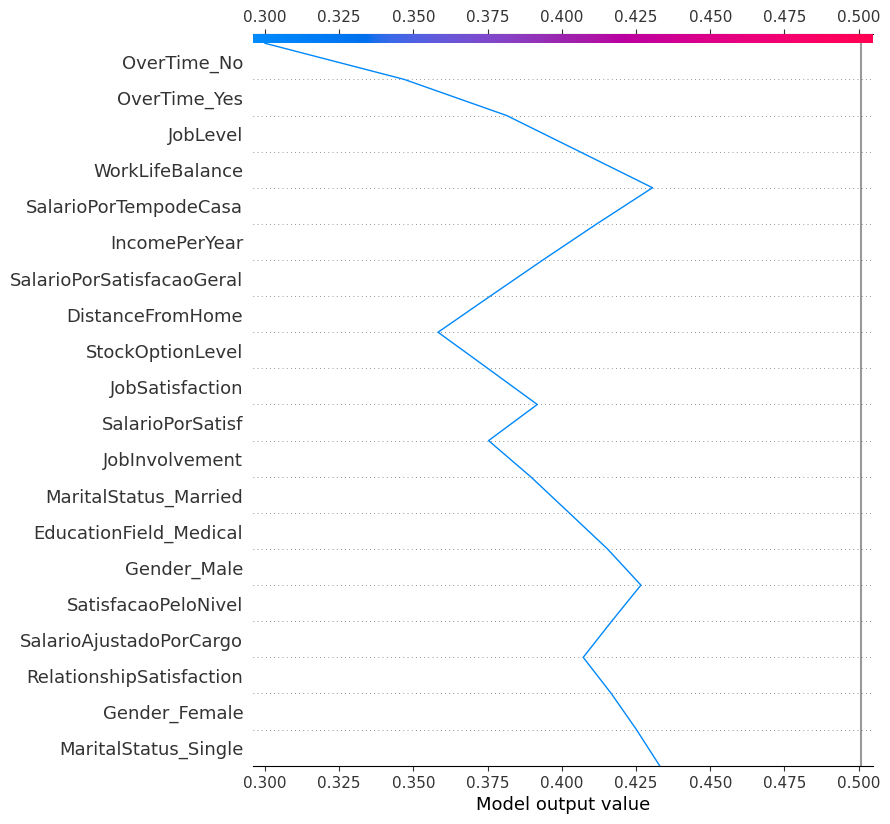

In [37]:
shap_values_plot = shap_values[:, :, 1] # 1 para a classe Attrition
shap.summary_plot(shap_values_plot, X_sample, plot_size=(12, 8))

shap.summary_plot(shap_values_plot, X_sample, plot_type="bar")

shap.dependence_plot("SalarioPorSatisf", shap_values_plot, X_sample)

shap.decision_plot(explainer.expected_value[1], shap_values_plot[0, :], X_sample.columns)

# Treinamento dos modelos

### avaliacao modelo

* Matriz de Confusão
    * 0 = classe negativa (ficou), 1 = classe positiva (saiu)
    * Linhas = Valor Real, Colunas = Predito
        * [0,0] (Topo esquerdo): Verdadeiros Negativos (acertou quem ficou)
        * [0,1] (Topo direito): Falsos Positivos (errou, previu que saiu mas ficou) 
        * [1,0] (Baixo esquerdo): Falsos Negativos (errou, previu que ficou mas saiu) 
        * [1,1] (Baixo direito): Verdadeiros Positivos (acertou quem saiu)
* Curva ROC e AUC
    * ROC = Receiver Operating Characteristic
        * Eixo X: Falso Positivo (FP rate)
        * Eixo Y: Verdadeiro Positivo (TP rate)

    * AUC: Área sob a curva ROC. Mede a capacidade do modelo distinguir as classes.
        * AUC = 0.5 → Modelo aleatório (sem poder preditivo)
        * AUC = 1.0 → Modelo perfeito
* Curva Precision-Recall
    * Precision (Precisão): Dos que o modelo disse que “saiu”, quantos saíram de verdade?
    * Recall (Sensibilidade): Dos que saíram de verdade, quantos o modelo encontrou?
    * Curva: Mostra o trade-off entre tentar acertar todos (recall alto) e não errar muito (precision alto).

In [ ]:
def save_pickle_model(model, path, name):
    if model.get_params()["scale_pos_weight"]:
        print('entrou no class weight')
        with open(f'{path}/{name}.pkl', 'wb') as f:
            pickle.dump(model, f)
    else:
        print('entrou no oversampling')
        with open(f'{path}/{name}.pkl', 'wb') as f:
            pickle.dump(model, f)


In [ ]:
def save_pickle_model(model, path, name):
    with open(f'{path}/{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

### xgboost

In [101]:
path_save_class = 'data/pickle/balanceado/classweight/minMaxScaler'
path_save_over = 'data/pickle/balanceado/Oversampling/minMaxScaler'

#### Com balanciamento class_weight

In [97]:
# Para classes 0 e 1 (ajuste se seu problema for diferente)
counter = Counter(y_train)
n_0 = counter[0]  # Ex: ficou
n_1 = counter[1]  # Ex: saiu

scale_pos_weight = n_0 / n_1
scale_pos_weight

4.571030640668524

In [115]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=4, scale_pos_weight=scale_pos_weight)


XGBoost
              precision    recall  f1-score   support

         0.0      0.826     0.896     0.860      1641
         1.0      0.224     0.136     0.170       359

    accuracy                          0.760      2000
   macro avg      0.525     0.516     0.515      2000
weighted avg      0.718     0.760     0.736      2000



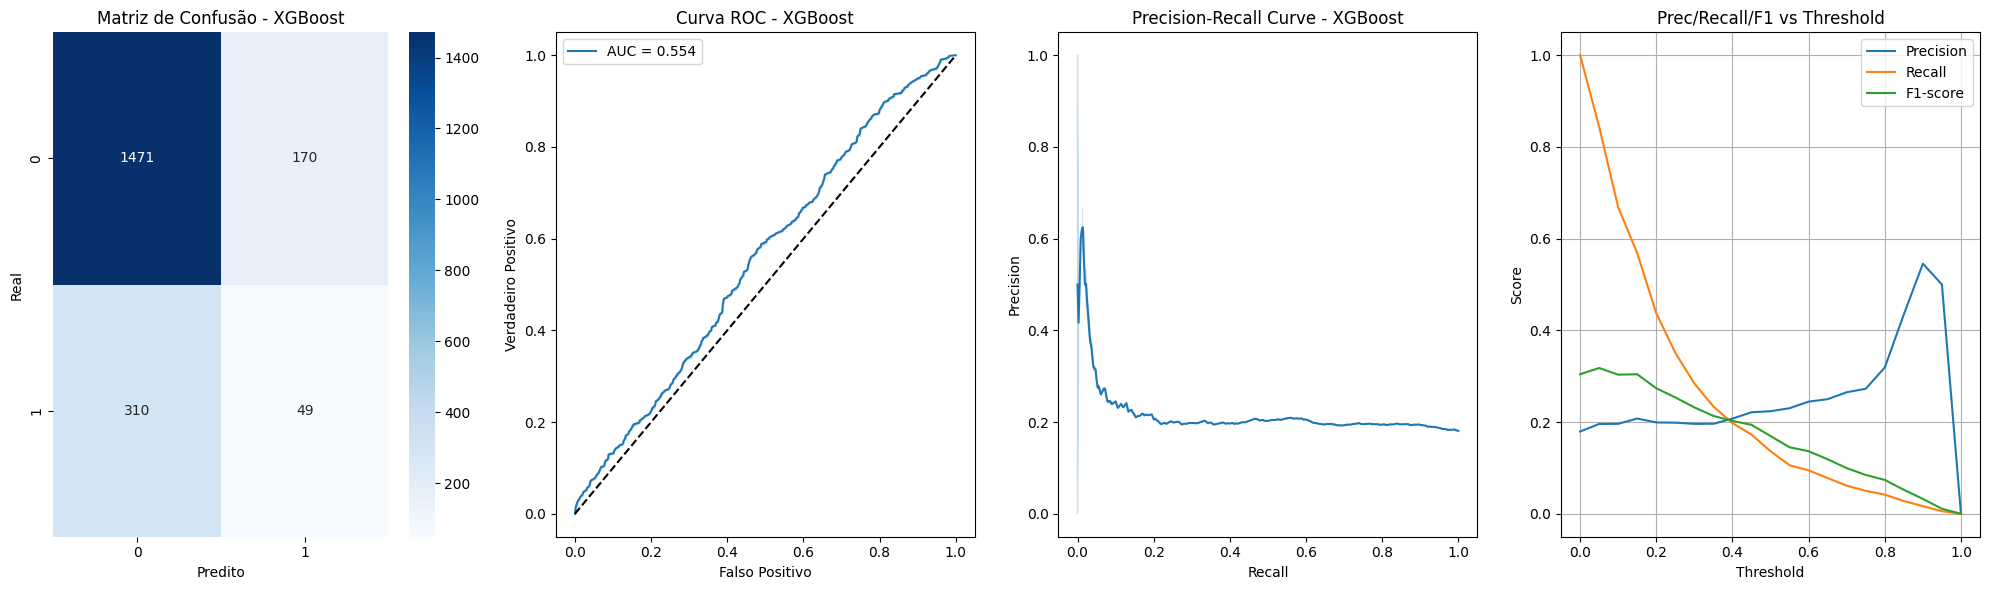

In [116]:
nome='XGBoost'
avaliar_modelo(xgb_model, X_train_minmax, X_test_minmax, y_train, y_test, nome=nome)

In [117]:
if xgb_model.get_params()["scale_pos_weight"]:
    print('entrou no class weight')
    save_pickle_model(xgb_model, path_save_class, nome)
else:
    print('entrou no oversampling')
    save_pickle_model(xgb_model, path_save_over, nome)
    

entrou no class weight


#### Com balanciamento over

In [118]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=4)


XGBoost
              precision    recall  f1-score   support

         0.0      0.826     0.963     0.889      1641
         1.0      0.294     0.070     0.113       359

    accuracy                          0.803      2000
   macro avg      0.560     0.517     0.501      2000
weighted avg      0.730     0.803     0.750      2000



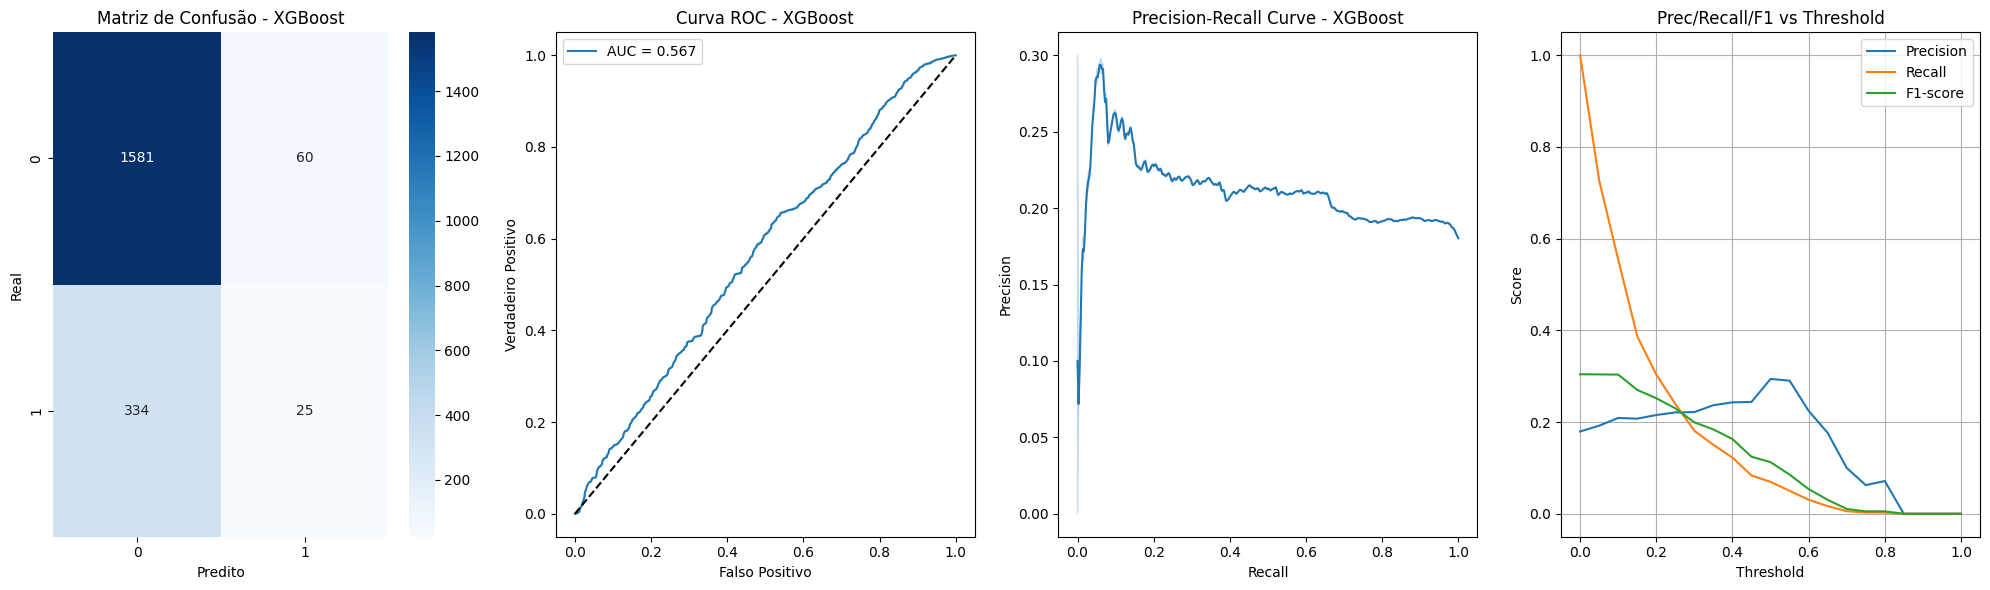

In [120]:
avaliar_modelo(xgb_model, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='XGBoost')

In [121]:
if xgb_model.get_params()["scale_pos_weight"]:
    print('entrou no class weight')
    save_pickle_model(xgb_model, path_save_class, nome)
else:
    print('entrou no oversampling')
    save_pickle_model(xgb_model, path_save_over, nome)
    

entrou no oversampling


#### Hiperparamtros

##### GridSearchCV
    Testa todas as combinações de parâmetros que você definir.

In [123]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_minmax_over, y_train_over)
print("GridSearchCV XGB:", grid_xgb.best_params_)

/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/

GridSearchCV XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}



XGBoost (Grid)
              precision    recall  f1-score   support

         0.0      0.822     0.994     0.900      1641
         1.0      0.333     0.014     0.027       359

    accuracy                          0.818      2000
   macro avg      0.577     0.504     0.463      2000
weighted avg      0.734     0.818     0.743      2000



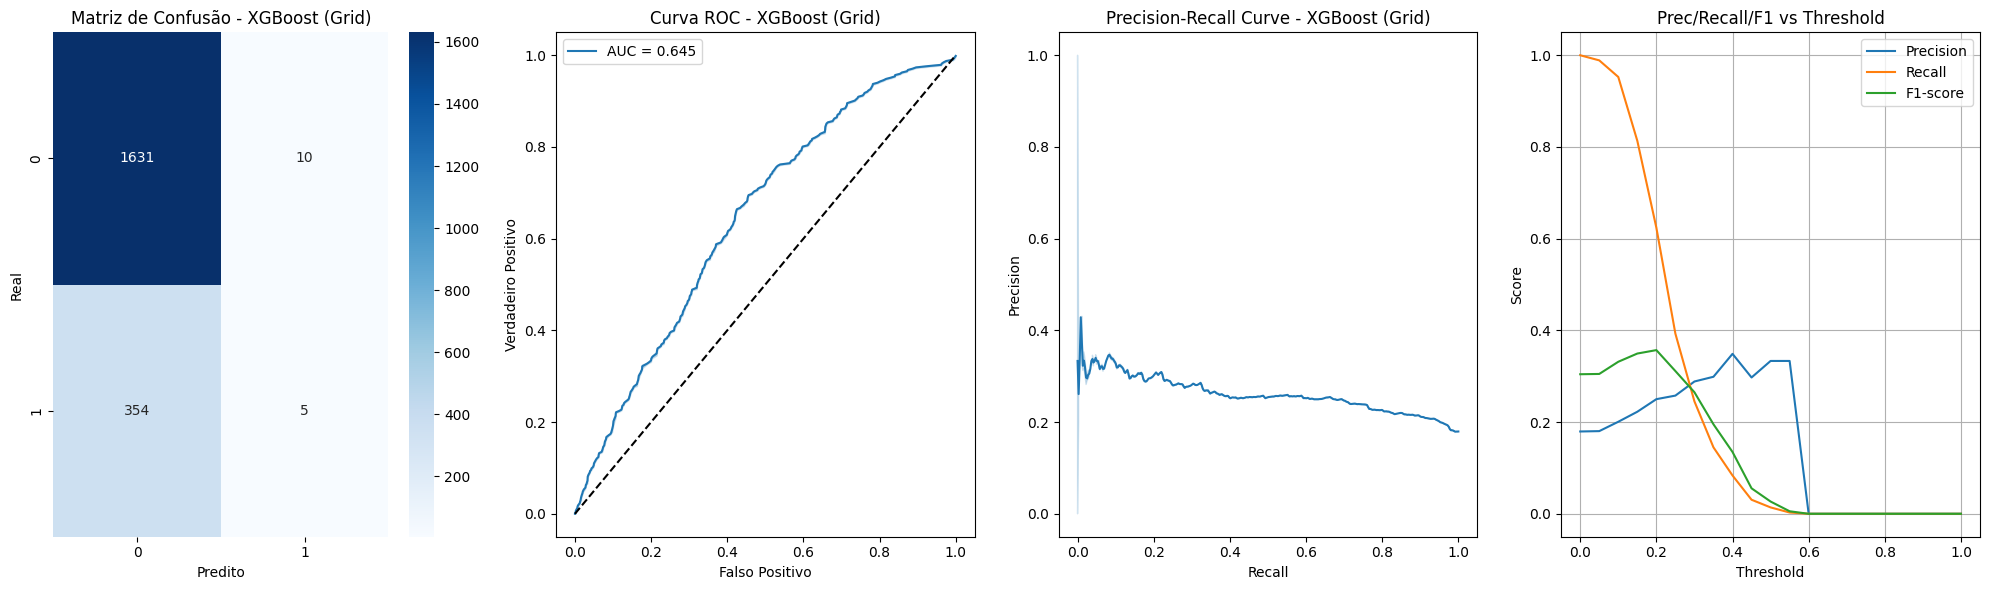

In [126]:
nome='XGBoost (Grid)'
avaliar_modelo(grid_xgb.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='XGBoost (Grid)')

In [127]:
if grid_xgb.best_estimator_.get_params()["scale_pos_weight"]:
    print('entrou no class weight')
    save_pickle_model(grid_xgb.best_estimator_, path_save_class, nome)
else:
    print('entrou no oversampling')
    save_pickle_model(grid_xgb.best_estimator_, path_save_over, nome)
    

entrou no oversampling


##### RandomizedSearchCV
    Testa combinações aleatórias dos parâmetros (mais rápido quando tem muitas opções).

In [129]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}
rnd_xgb = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                             param_distributions=param_dist_xgb, n_iter=10, cv=3, scoring='f1', n_jobs=-1)
rnd_xgb.fit(X_train_minmax_over, y_train_over)
print("RandomizedSearchCV XGB:", rnd_xgb.best_params_)

/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/

RandomizedSearchCV XGB: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}



XGBoost (Random)
              precision    recall  f1-score   support

         0.0      0.823     0.986     0.897      1641
         1.0      0.343     0.033     0.061       359

    accuracy                          0.815      2000
   macro avg      0.583     0.510     0.479      2000
weighted avg      0.737     0.815     0.747      2000



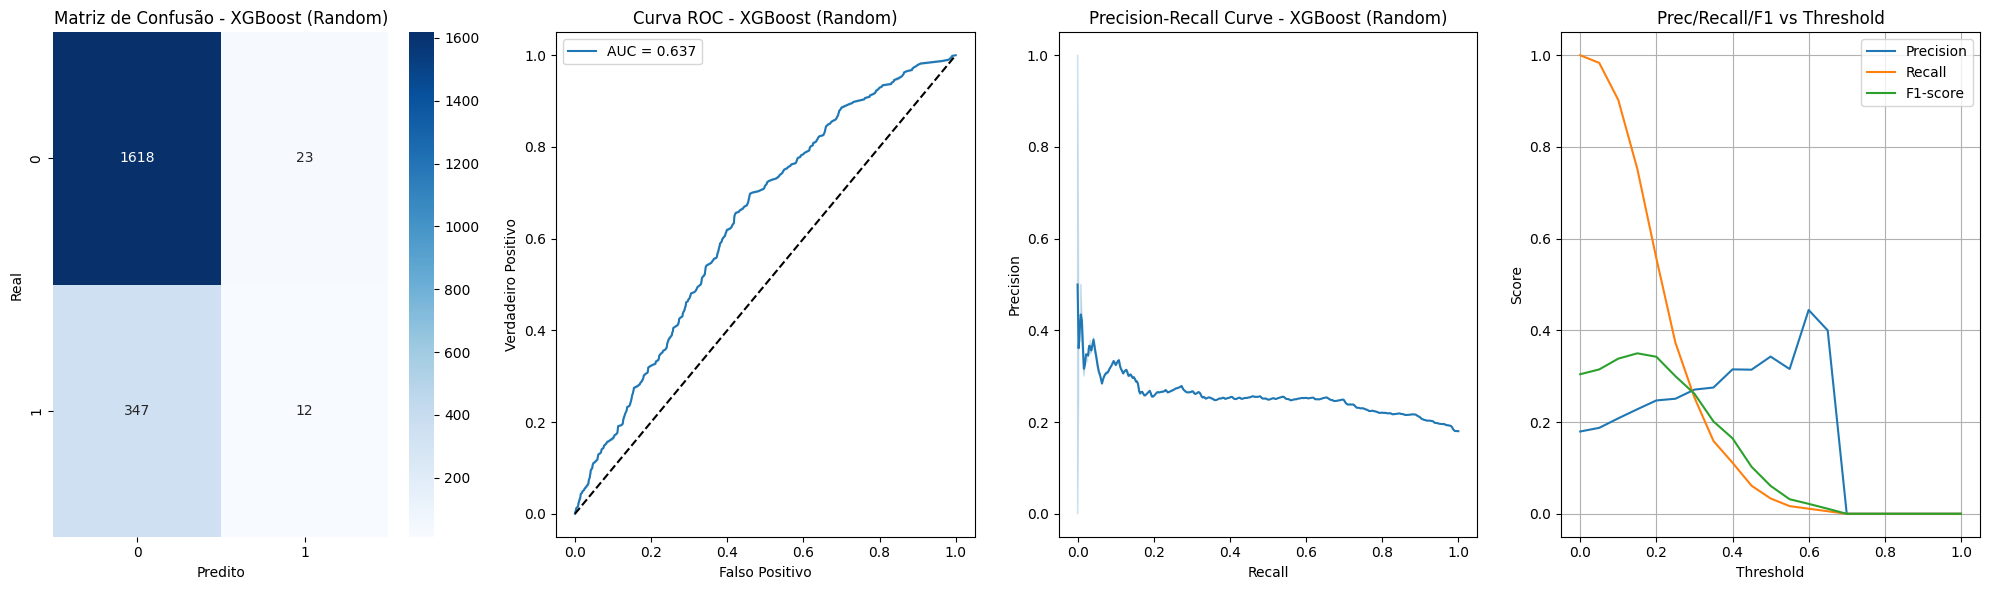

In [130]:
nome='XGBoost (Random)'
avaliar_modelo(rnd_xgb.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome=nome)

In [132]:
if rnd_xgb.best_estimator_.get_params()["scale_pos_weight"]:
    print('entrou no class weight')
    save_pickle_model(rnd_xgb.best_estimator_, path_save_class, nome)
else:
    print('entrou no oversampling')
    save_pickle_model(rnd_xgb.best_estimator_, path_save_over, nome)

entrou no oversampling


##### Otimização bayesiana
    A otimização bayesiana é uma técnica baseada no teorema de Bayes, que descreve a probabilidade de ocorrência de um evento relacionado ao conhecimento atual

In [133]:
search_spaces_xgb = {
    'n_estimators': (100, 300),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.8, 1.0)
}
opt_xgb = BayesSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    search_spaces=search_spaces_xgb,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)
opt_xgb.fit(X_train_minmax_over, y_train_over)
print("BayesSearchCV XGB:", opt_xgb.best_params_)

/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:13:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:13:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:13:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hbarboza/

BayesSearchCV XGB: OrderedDict({'learning_rate': 0.06252364429596796, 'max_depth': 3, 'n_estimators': 127, 'subsample': 0.8})



XGBoost (Bayes)
              precision    recall  f1-score   support

         0.0      0.822     0.996     0.901      1641
         1.0      0.417     0.014     0.027       359

    accuracy                          0.820      2000
   macro avg      0.619     0.505     0.464      2000
weighted avg      0.749     0.820     0.744      2000



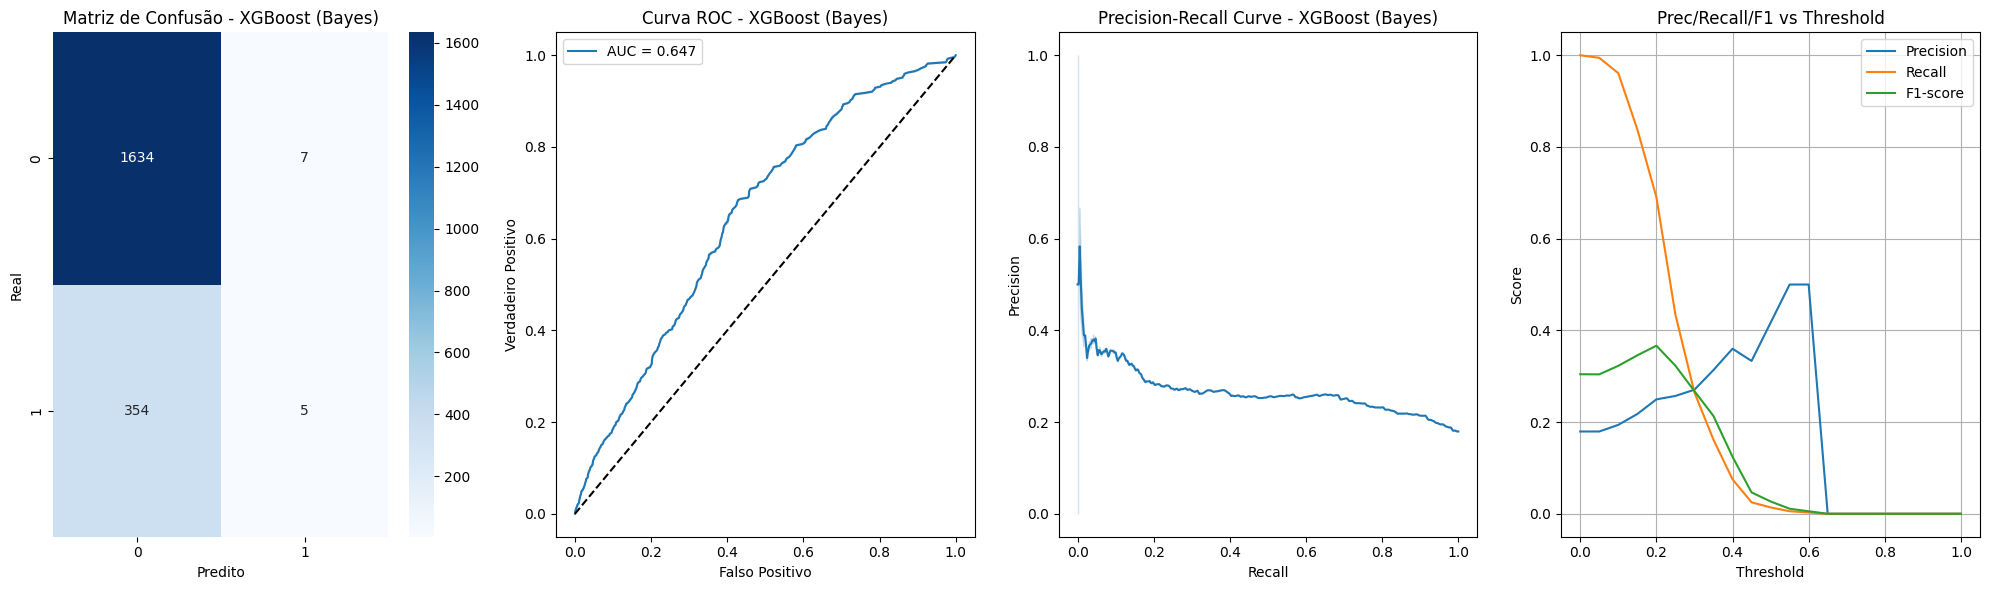

In [134]:
nome='XGBoost (Bayes)'
avaliar_modelo(opt_xgb.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome=nome)

In [135]:
if opt_xgb.best_estimator_.get_params()["scale_pos_weight"]:
    print('entrou no class weight')
    save_pickle_model(opt_xgb.best_estimator_, path_save_class, nome)
else:
    print('entrou no oversampling')
    save_pickle_model(opt_xgb.best_estimator_, path_save_over, nome)

entrou no oversampling


##### Optuna
    é um dos frameworks mais modernos para hyperparameter tuning, super flexível e fácil de usar.
    Ele funciona diferente: você define uma função de objetivo, e o Optuna faz os testes.

In [136]:

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    model = xgb.XGBClassifier(**params)
    score = cross_val_score(model, X_train_minmax_over, y_train_over, cv=3, scoring='f1').mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)
print("Optuna XGB:", study_xgb.best_params)
best_xgb_optuna = xgb.XGBClassifier(**study_xgb.best_params)
best_xgb_optuna.fit(X_train_minmax_over, y_train_over)

[I 2025-07-16 21:15:01,613] A new study created in memory with name: no-name-329924f6-c932-4d6c-ad65-a753348005d6


[I 2025-07-16 21:15:02,455] Trial 0 finished with value: 0.8220058302371398 and parameters: {'n_estimators': 237, 'max_depth': 3, 'learning_rate': 0.10339209954097546, 'subsample': 0.9082532320525295}. Best is trial 0 with value: 0.8220058302371398.
[I 2025-07-16 21:15:03,204] Trial 1 finished with value: 0.8303413077952359 and parameters: {'n_estimators': 167, 'max_depth': 4, 'learning_rate': 0.02152821150664125, 'subsample': 0.8737503108279985}. Best is trial 1 with value: 0.8303413077952359.
[I 2025-07-16 21:15:04,549] Trial 2 finished with value: 0.8129432529384033 and parameters: {'n_estimators': 202, 'max_depth': 6, 'learning_rate': 0.14224821862711104, 'subsample': 0.8156074138649897}. Best is trial 1 with value: 0.8303413077952359.
[I 2025-07-16 21:15:08,253] Trial 3 finished with value: 0.8244030386221405 and parameters: {'n_estimators': 183, 'max_depth': 10, 'learning_rate': 0.012820300094554848, 'subsample': 0.8060702697699416}. Best is trial 1 with value: 0.8303413077952359

Optuna XGB: {'n_estimators': 167, 'max_depth': 4, 'learning_rate': 0.02152821150664125, 'subsample': 0.8737503108279985}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02152821150664125, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=167, n_jobs=None,
              num_parallel_tree=None, ...)


XGBoost (Optuna)
              precision    recall  f1-score   support

         0.0      0.820     0.999     0.901      1641
         1.0      0.000     0.000     0.000       359

    accuracy                          0.820      2000
   macro avg      0.410     0.500     0.451      2000
weighted avg      0.673     0.820     0.739      2000



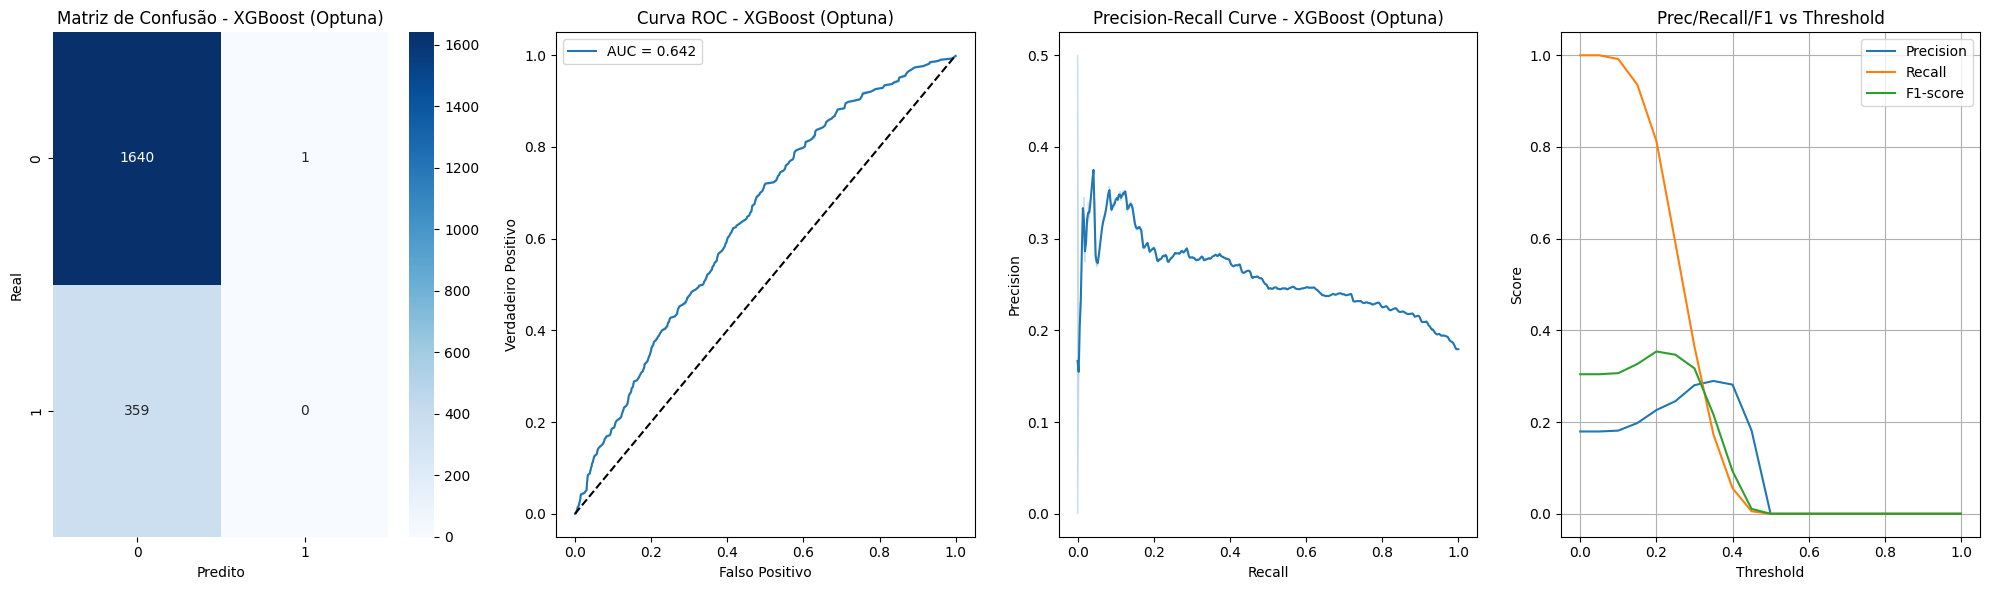

In [137]:
nome='XGBoost (Optuna)'
avaliar_modelo(best_xgb_optuna, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome=nome)

In [138]:
if best_xgb_optuna.get_params()["scale_pos_weight"]:
    print('entrou no class weight')
    save_pickle_model(best_xgb_optuna, path_save_class, nome)
else:
    print('entrou no oversampling')
    save_pickle_model(best_xgb_optuna, path_save_over, nome)

entrou no oversampling


### random forest

In [139]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


Random Forest
              precision    recall  f1-score   support

         0.0      0.820     0.995     0.899      1641
         1.0      0.000     0.000     0.000       359

    accuracy                          0.817      2000
   macro avg      0.410     0.498     0.449      2000
weighted avg      0.673     0.817     0.738      2000



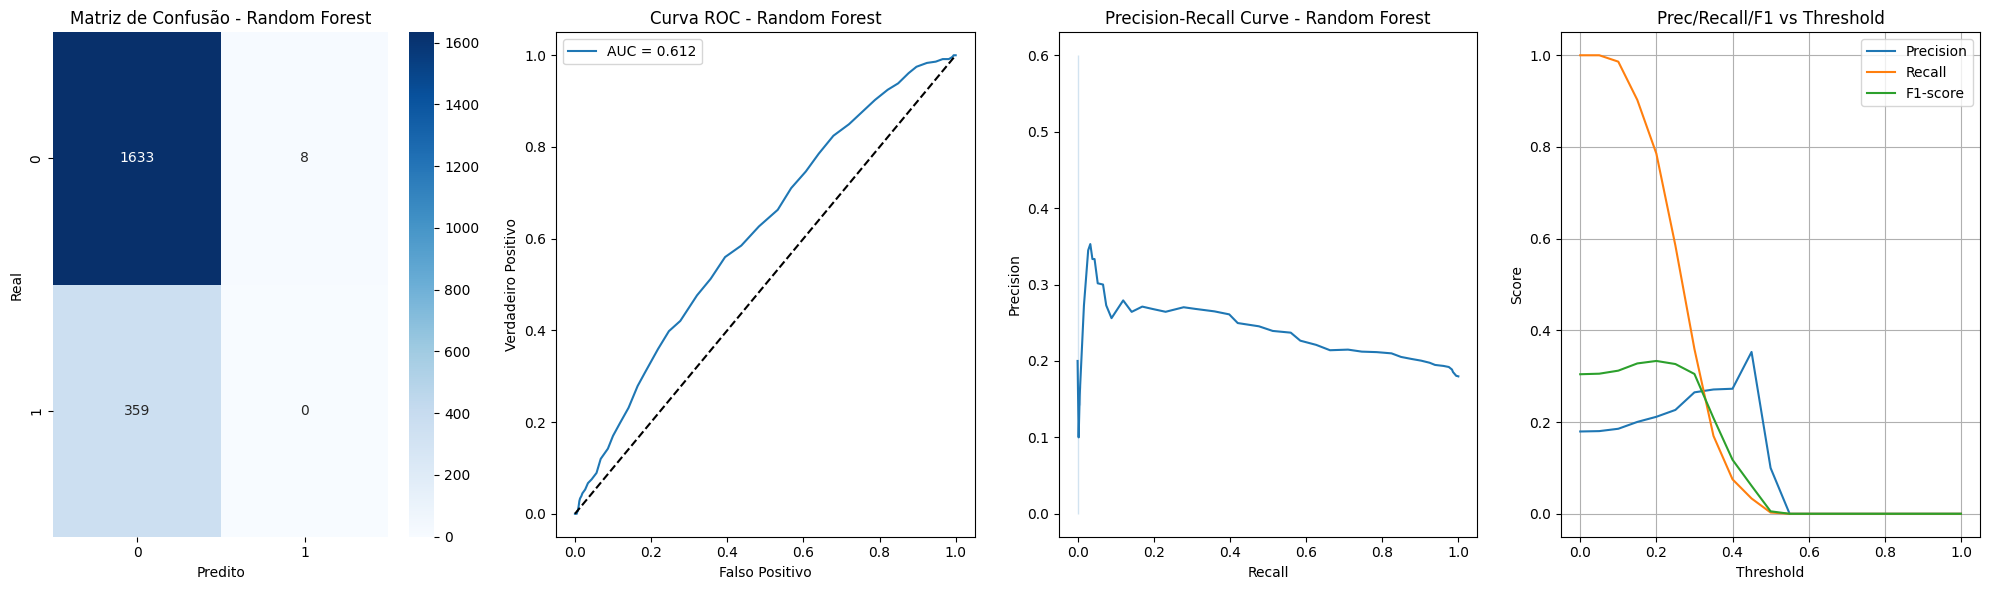

In [140]:
avaliar_modelo(rf_model, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Random Forest')

#### Hiperparamtros

##### GridSearchCV
    Testa todas as combinações de parâmetros que você definir.

In [141]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_minmax_over, y_train_over)
print("Melhores parâmetros:", grid.best_params_)
best_rf = grid.best_estimator_

Melhores parâmetros: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}



Random Forest (GridSearchCV)
              precision    recall  f1-score   support

         0.0      0.820     0.998     0.900      1641
         1.0      0.000     0.000     0.000       359

    accuracy                          0.819      2000
   macro avg      0.410     0.499     0.450      2000
weighted avg      0.673     0.819     0.739      2000



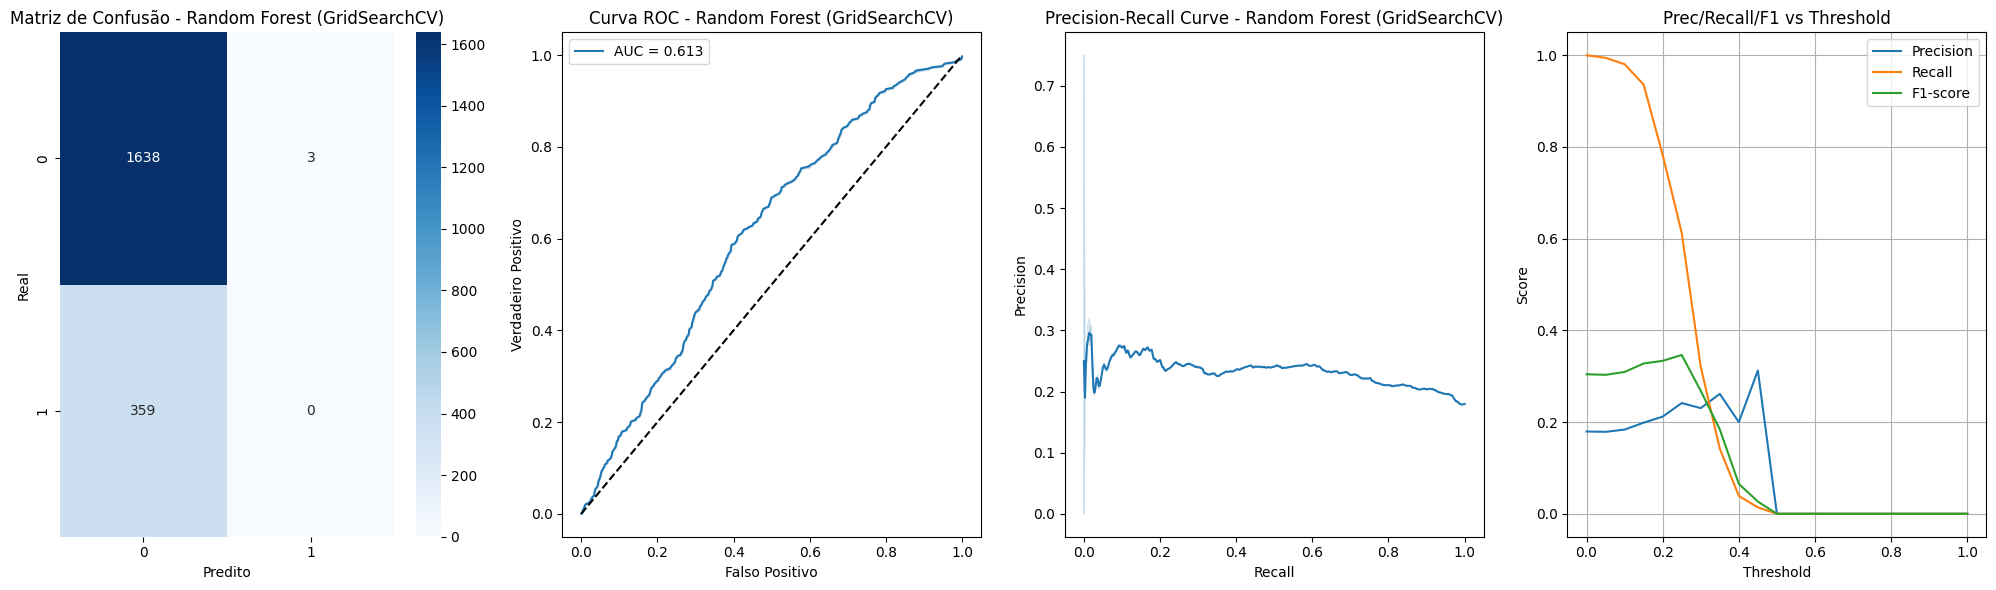

In [142]:
avaliar_modelo(best_rf, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Random Forest (GridSearchCV)')

##### RandomizedSearchCV
    Testa combinações aleatórias dos parâmetros (mais rápido quando tem muitas opções).

In [143]:
param_dist = {
    'max_depth': [3, 5, 7, None],
    'n_estimators': [50, 100, 200, 300],
    'min_samples_split': [2, 5, 10]
}
rnd = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)
rnd.fit(X_train_minmax_over, y_train_over)
print("Melhores parâmetros:", rnd.best_params_)
best_rf_rnd = rnd.best_estimator_

Melhores parâmetros: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}



Random Forest (RandomizedSearchCV)
              precision    recall  f1-score   support

         0.0      0.820     0.998     0.900      1641
         1.0      0.000     0.000     0.000       359

    accuracy                          0.819      2000
   macro avg      0.410     0.499     0.450      2000
weighted avg      0.673     0.819     0.739      2000



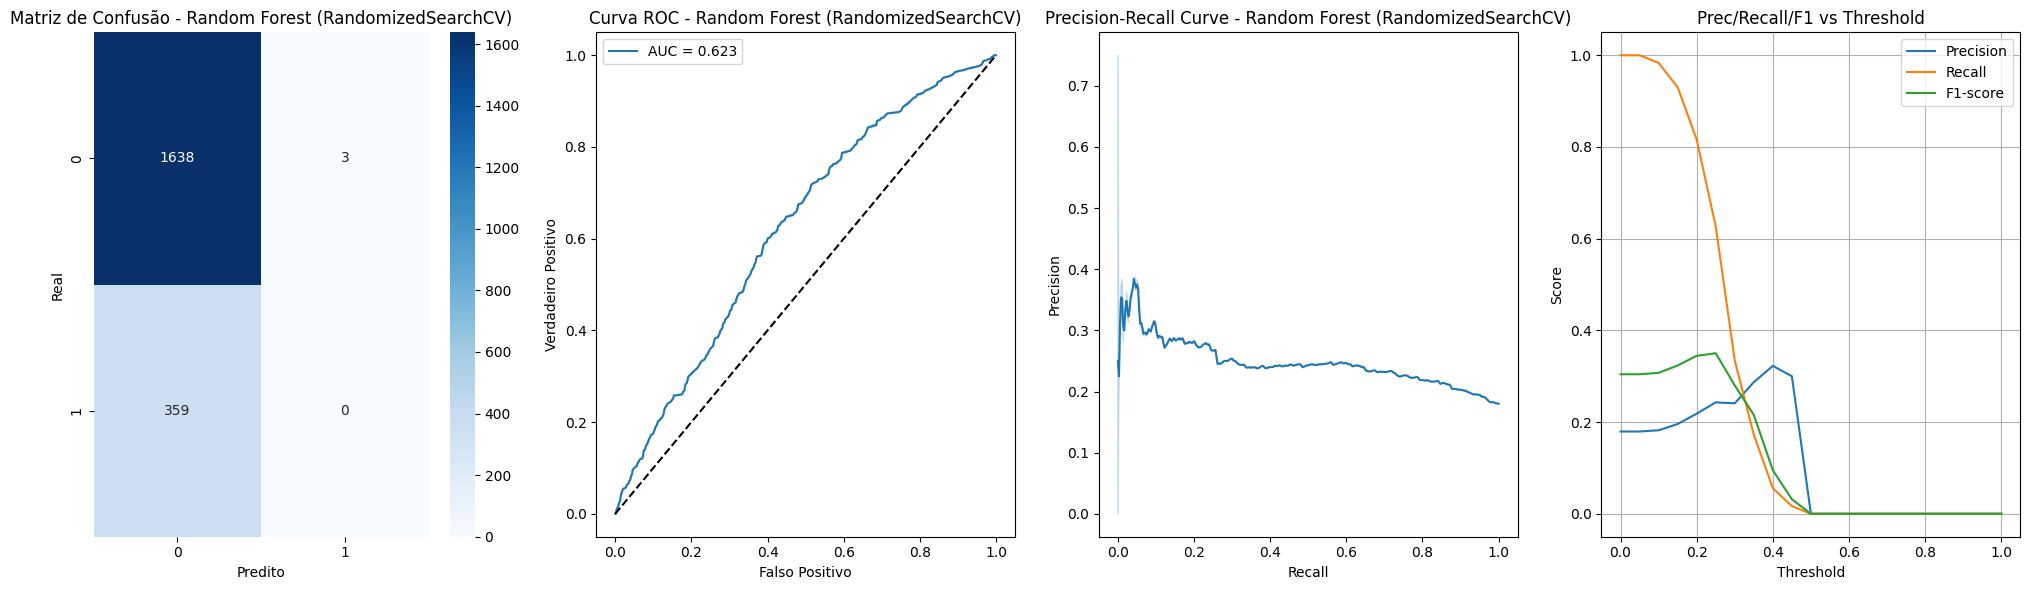

In [144]:
avaliar_modelo(best_rf_rnd, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Random Forest (RandomizedSearchCV)')

##### Otimização bayesiana
    A otimização bayesiana é uma técnica baseada no teorema de Bayes, que descreve a probabilidade de ocorrência de um evento relacionado ao conhecimento atual

In [145]:
search_spaces = {
    'max_depth': (3, 30),  # valores inteiros entre 3 e 30
    'n_estimators': (50, 500),
    'min_samples_split': (2, 20)
}

opt = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces=search_spaces,
    n_iter=20,  # número de avaliações de combinações
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_train_minmax_over, y_train_over)
print("Melhores parâmetros (Bayesian):", opt.best_params_)
best_rf_bayes = opt.best_estimator_


Melhores parâmetros (Bayesian): OrderedDict({'max_depth': 27, 'min_samples_split': 2, 'n_estimators': 500})



Random Forest (BayesSearchCV)
              precision    recall  f1-score   support

         0.0      0.820     0.999     0.901      1641
         1.0      0.000     0.000     0.000       359

    accuracy                          0.820      2000
   macro avg      0.410     0.499     0.450      2000
weighted avg      0.673     0.820     0.739      2000



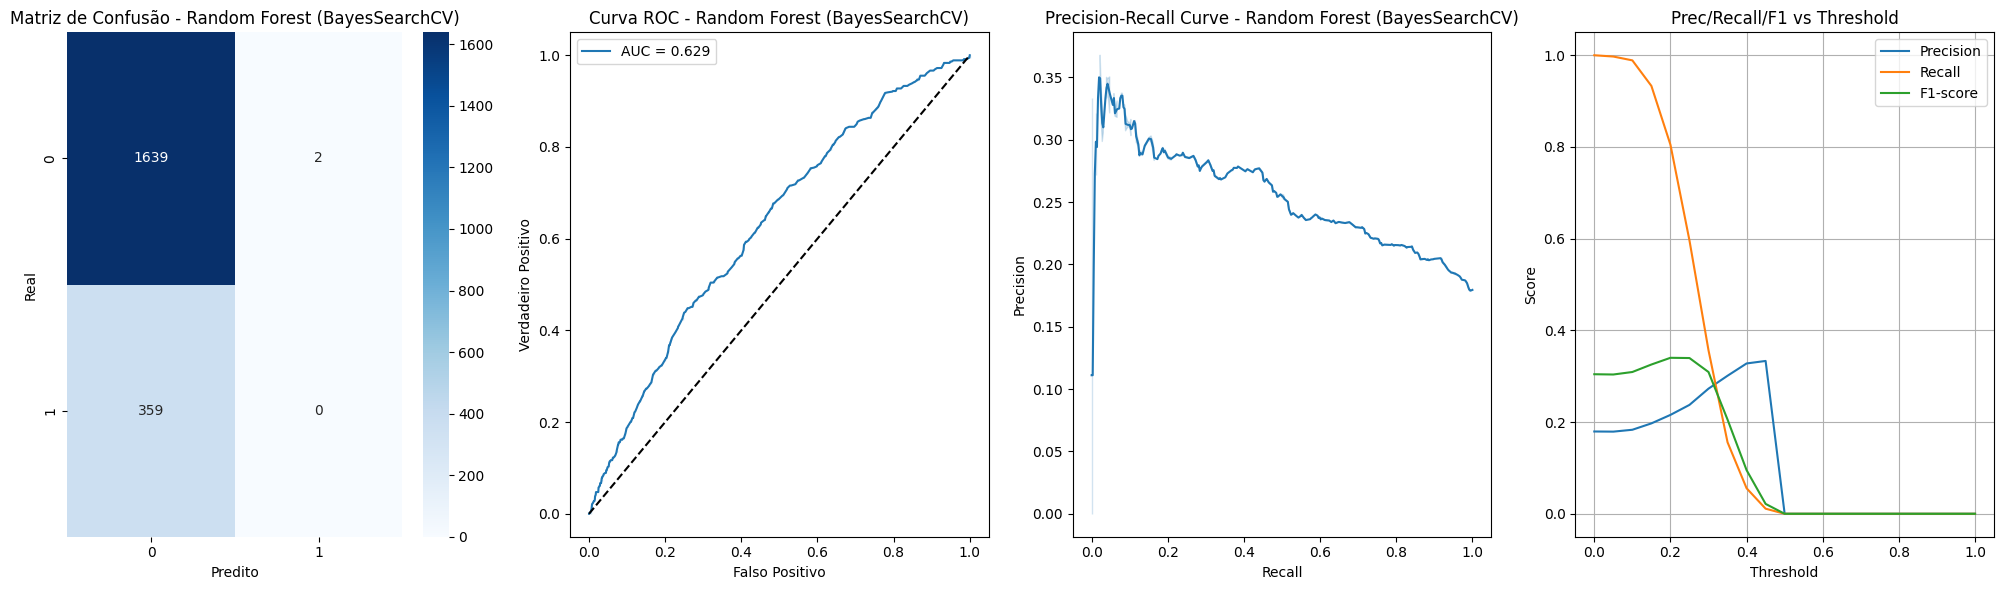

In [146]:
avaliar_modelo(best_rf_bayes, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Random Forest (BayesSearchCV)')

##### Optuna
    é um dos frameworks mais modernos para hyperparameter tuning, super flexível e fácil de usar.
    Ele funciona diferente: você define uma função de objetivo, e o Optuna faz os testes.

In [147]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    clf = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    score = cross_val_score(clf, X_train_minmax_over, y_train_over, cv=3, scoring='f1').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # aumenta n_trials para tunagem mais longa

print("Melhores parâmetros (Optuna):", study.best_params)
best_rf_optuna = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf_optuna.fit(X_train_minmax_over, y_train_over)


[I 2025-07-16 21:20:34,198] A new study created in memory with name: no-name-585f263c-0ff1-406e-9e61-454d057f604c
[I 2025-07-16 21:20:36,480] Trial 0 finished with value: 0.832357360956395 and parameters: {'max_depth': 11, 'n_estimators': 369, 'min_samples_split': 16}. Best is trial 0 with value: 0.832357360956395.
[I 2025-07-16 21:20:38,392] Trial 1 finished with value: 0.8335926624651963 and parameters: {'max_depth': 26, 'n_estimators': 278, 'min_samples_split': 14}. Best is trial 1 with value: 0.8335926624651963.
[I 2025-07-16 21:20:40,049] Trial 2 finished with value: 0.8330630014164803 and parameters: {'max_depth': 26, 'n_estimators': 236, 'min_samples_split': 9}. Best is trial 1 with value: 0.8335926624651963.
[I 2025-07-16 21:20:43,107] Trial 3 finished with value: 0.8339899627600196 and parameters: {'max_depth': 25, 'n_estimators': 430, 'min_samples_split': 4}. Best is trial 3 with value: 0.8339899627600196.
[I 2025-07-16 21:20:45,224] Trial 4 finished with value: 0.83329108388

Melhores parâmetros (Optuna): {'max_depth': 30, 'n_estimators': 479, 'min_samples_split': 5}


RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=479,
                       n_jobs=-1, random_state=42)


Random Forest (Optuna)
              precision    recall  f1-score   support

         0.0      0.821     0.999     0.901      1641
         1.0      0.333     0.003     0.006       359

    accuracy                          0.820      2000
   macro avg      0.577     0.501     0.453      2000
weighted avg      0.733     0.820     0.740      2000



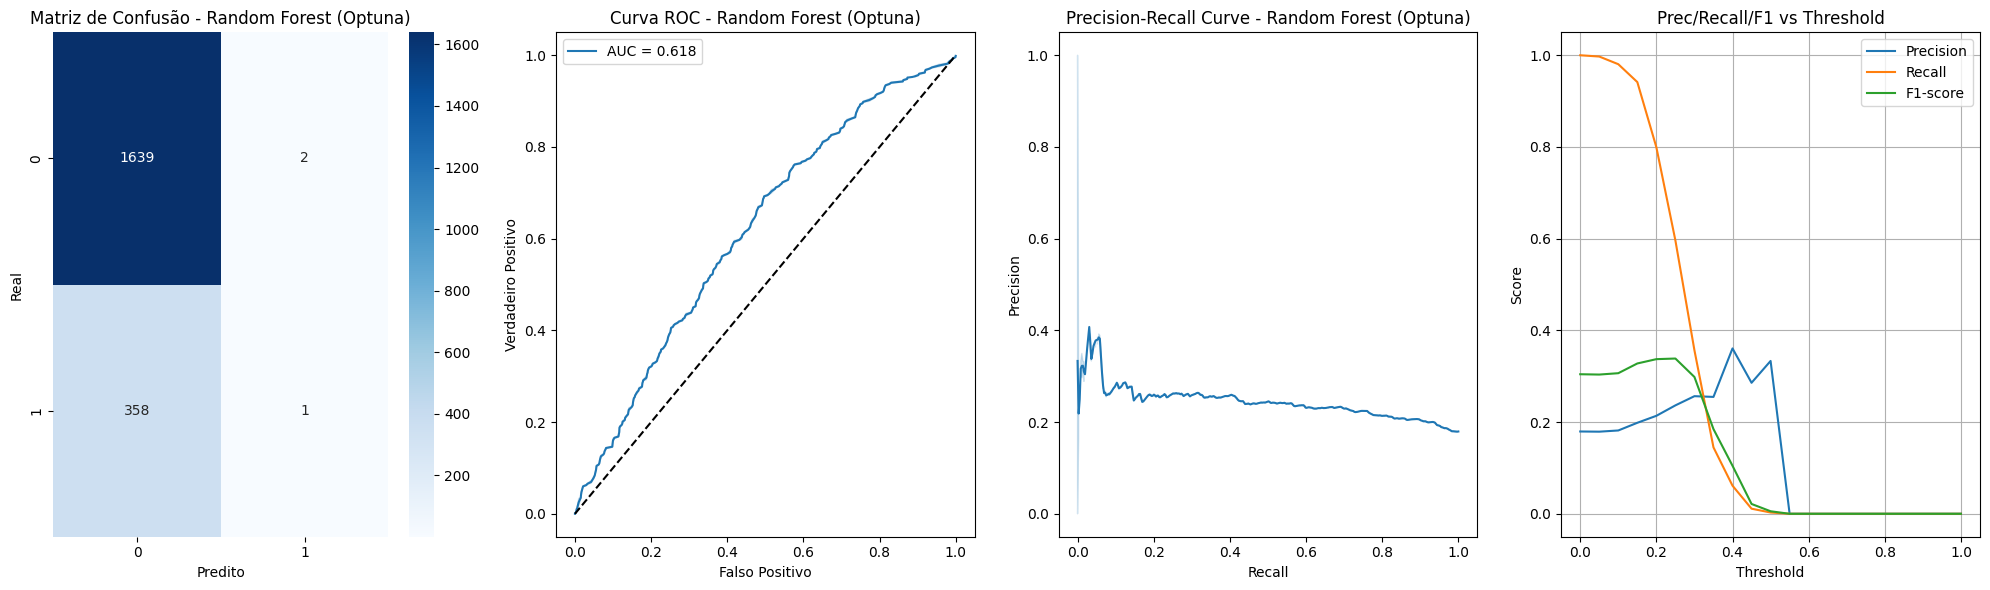

In [148]:
avaliar_modelo(best_rf_optuna, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Random Forest (Optuna)')

### Logistic Regression
    

In [149]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)


Logistic Regression
              precision    recall  f1-score   support

         0.0      0.863     0.601     0.709      1641
         1.0      0.236     0.563     0.333       359

    accuracy                          0.595      2000
   macro avg      0.549     0.582     0.521      2000
weighted avg      0.750     0.595     0.641      2000



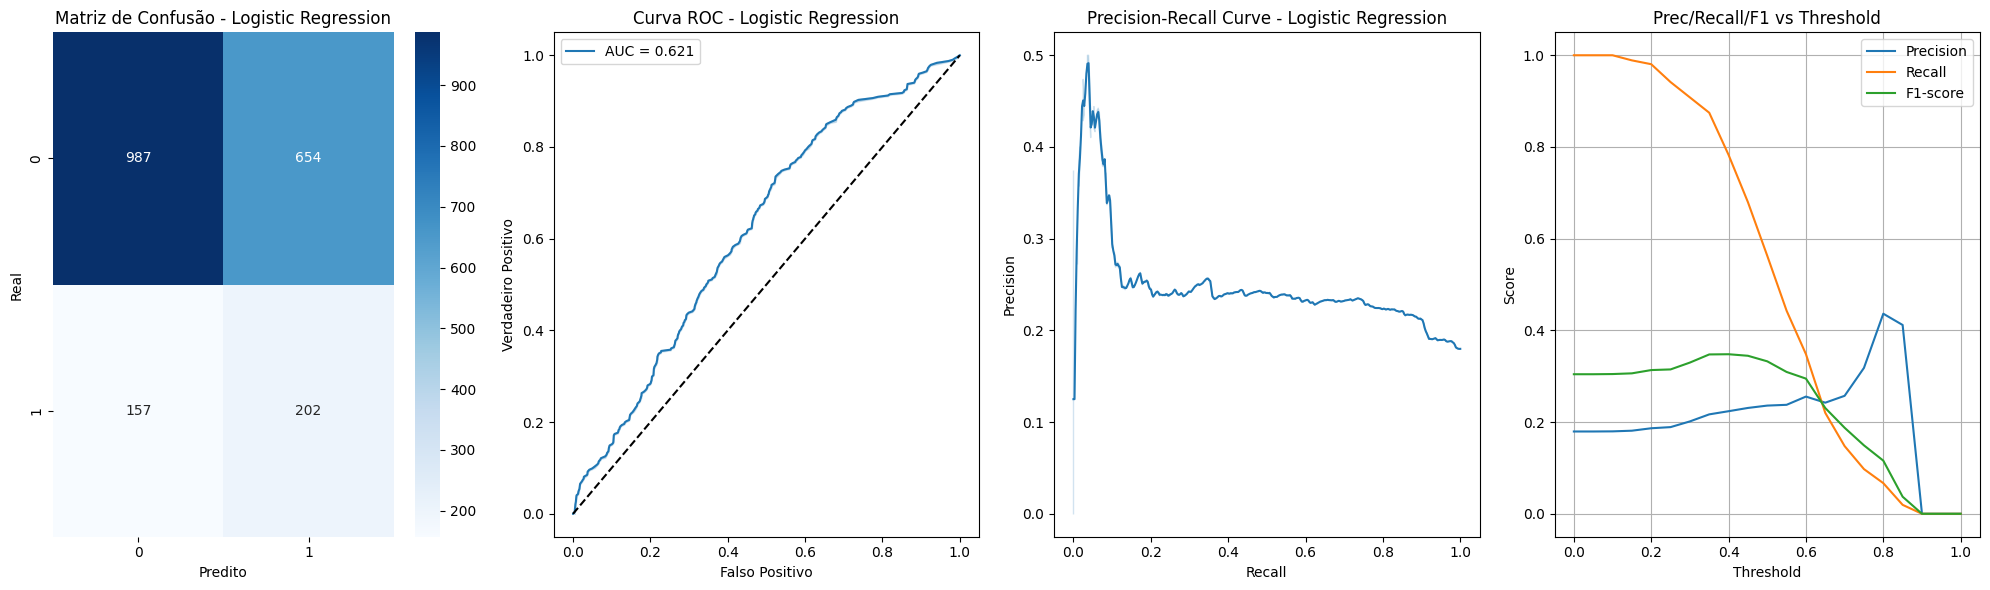

In [150]:
avaliar_modelo(lr_model, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Logistic Regression')

#### Hiperparamtros

##### GridSearchCV
    Testa todas as combinações de parâmetros que você definir.

In [151]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], # use 'l1' se solver='liblinear'
    'solver': ['lbfgs']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_minmax_over, y_train_over)
print("GridSearchCV LR:", grid_lr.best_params_)


/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @

GridSearchCV LR: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}



Logistic Regression (Grid)
              precision    recall  f1-score   support

         0.0      0.863     0.587     0.699      1641
         1.0      0.233     0.574     0.332       359

    accuracy                          0.585      2000
   macro avg      0.548     0.581     0.515      2000
weighted avg      0.750     0.585     0.633      2000



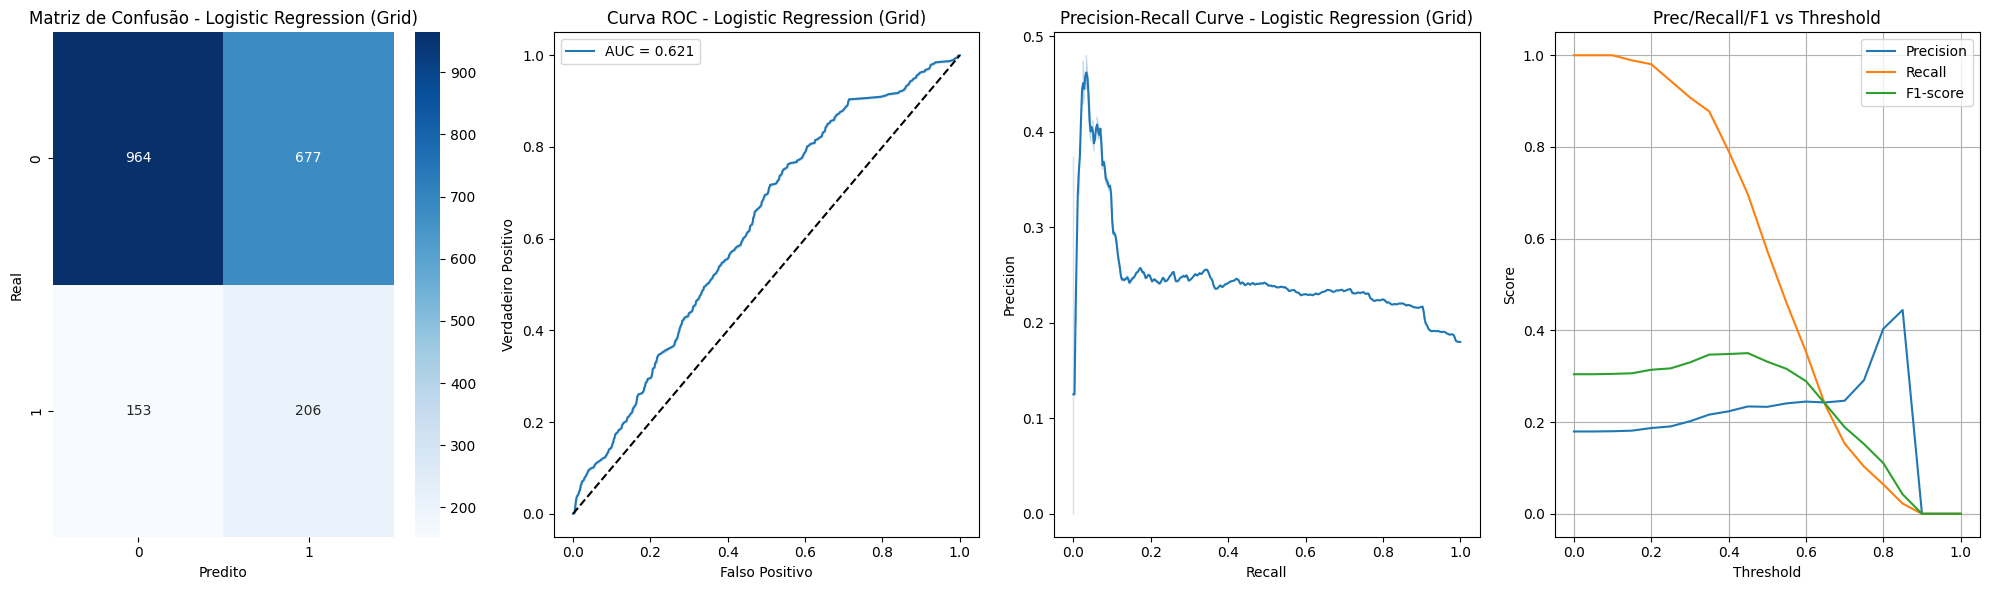

In [152]:
avaliar_modelo(grid_lr.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Logistic Regression (Grid)')

##### RandomizedSearchCV
    Testa combinações aleatórias dos parâmetros (mais rápido quando tem muitas opções).

In [153]:
param_randomized_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], # use 'l1' se solver='liblinear'
    'solver': ['lbfgs']
}
random_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_randomized_lr, cv=3, scoring='f1', n_jobs=-1)
random_lr.fit(X_train_minmax_over, y_train_over)
print("RandomizedSearchCV LR:", random_lr.best_params_)

/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = 

RandomizedSearchCV LR: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}



Logistic Regression (Randomized)
              precision    recall  f1-score   support

         0.0      0.821     0.995     0.900      1641
         1.0      0.308     0.011     0.022       359

    accuracy                          0.818      2000
   macro avg      0.565     0.503     0.461      2000
weighted avg      0.729     0.818     0.742      2000



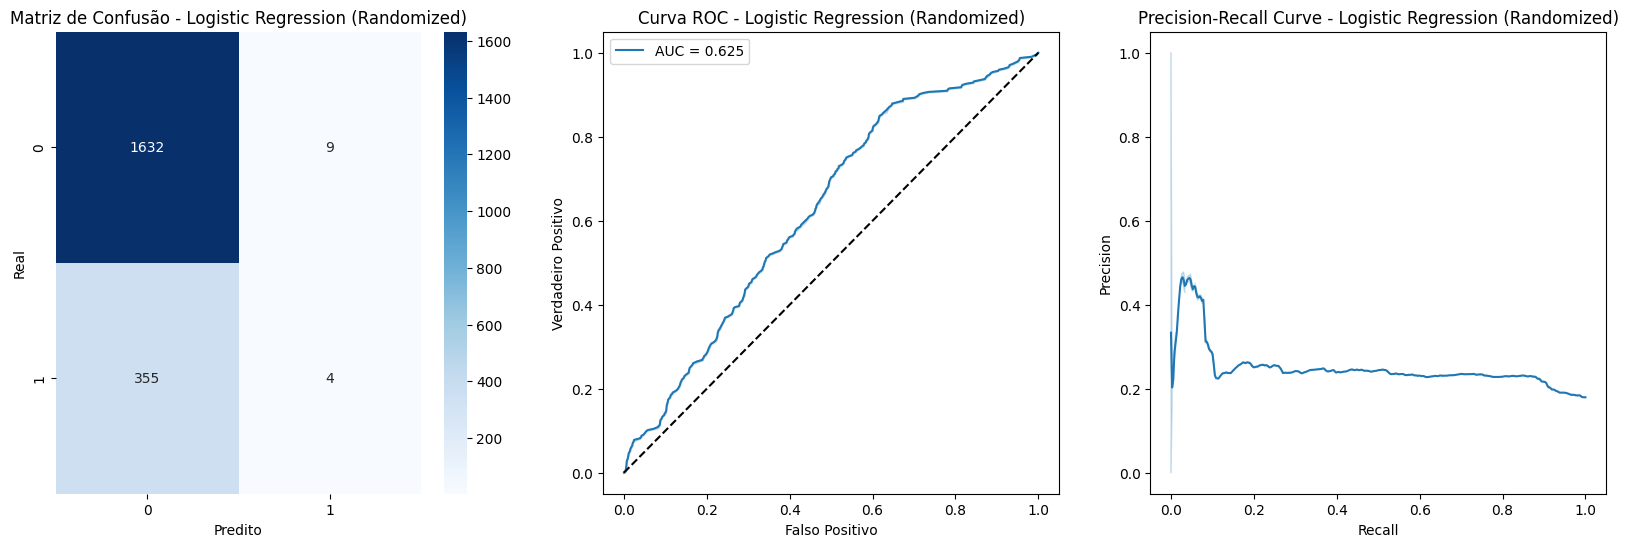

In [84]:
avaliar_modelo(random_lr.best_estimator_, X_train_minmax, X_test_minmax, y_train, y_test, nome='Logistic Regression (Randomized)')

##### Otimização bayesiana
    A otimização bayesiana é uma técnica baseada no teorema de Bayes, que descreve a probabilidade de ocorrência de um evento relacionado ao conhecimento atual

In [154]:
search_spaces_lr = {
    'C': (0.001, 10.0, 'log-uniform'),
    'solver': ['lbfgs', 'liblinear'],
}
bayes_lr = BayesSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    search_spaces=search_spaces_lr,
    n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42
)
bayes_lr.fit(X_train_minmax_over, y_train_over)
print("BayesSearchCV LR:", bayes_lr.best_params_)

/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hbarboza/Library/Caches/pypoetry/virtualenvs/dsx-mack-model-ibm-hr-_9YFYcqy-py3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py

BayesSearchCV LR: OrderedDict({'C': 6.6360850776123375, 'solver': 'liblinear'})



Logistic Regression (Bayes)
              precision    recall  f1-score   support

         0.0      0.821     0.995     0.900      1641
         1.0      0.273     0.008     0.016       359

    accuracy                          0.818      2000
   macro avg      0.547     0.502     0.458      2000
weighted avg      0.723     0.818     0.741      2000



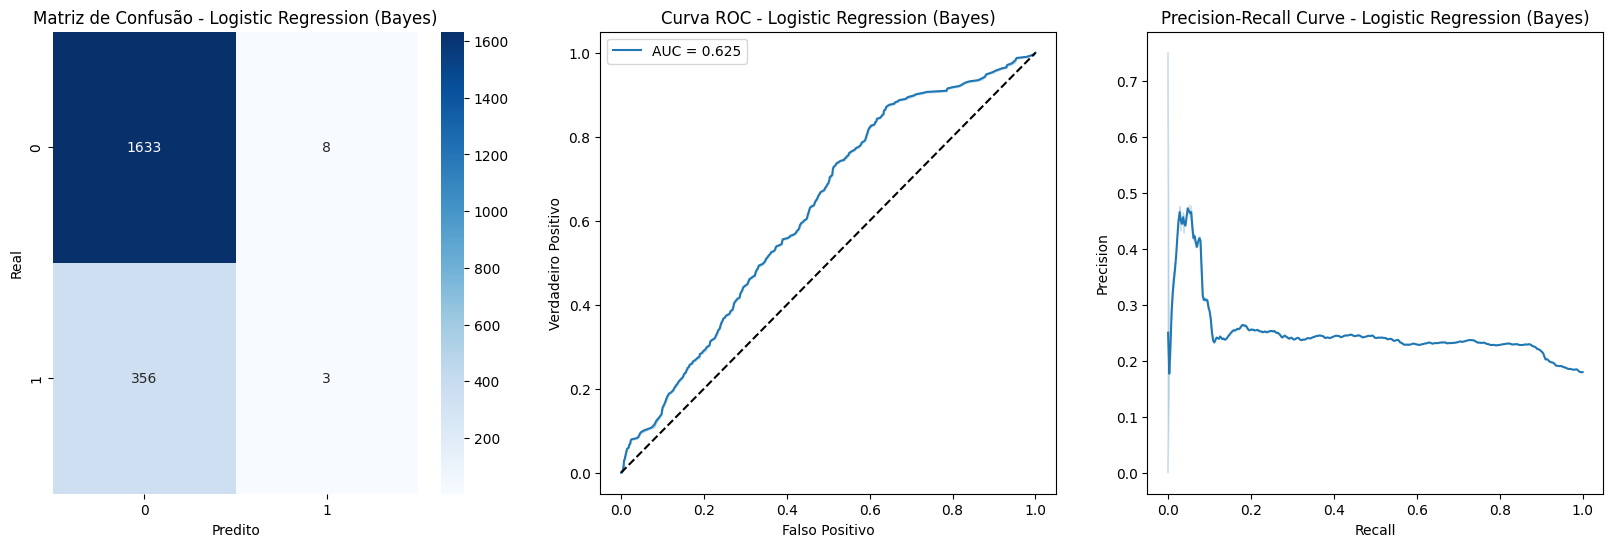

In [86]:
avaliar_modelo(bayes_lr.best_estimator_, X_train_minmax, X_test_minmax, y_train, y_test, nome='Logistic Regression (Bayes)')

##### Optuna
    é um dos frameworks mais modernos para hyperparameter tuning, super flexível e fácil de usar.
    Ele funciona diferente: você define uma função de objetivo, e o Optuna faz os testes.

In [155]:
def objective_lr(trial):
    C = trial.suggest_loguniform('C', 0.001, 10.0)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
    score = cross_val_score(model, X_train_minmax_over, y_train_over, cv=3, scoring='f1').mean()
    return score

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=10)
print("Optuna LR:", study_lr.best_params)
best_lr_optuna = LogisticRegression(**study_lr.best_params, max_iter=1000, random_state=42)
best_lr_optuna.fit(X_train_minmax_over, y_train_over)


[I 2025-07-16 21:21:33,832] A new study created in memory with name: no-name-37c30f68-bd50-447e-87d8-cd41dace506a
[I 2025-07-16 21:21:33,973] Trial 0 finished with value: 0.6131040068597193 and parameters: {'C': 0.00474519138438496, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6131040068597193.
[I 2025-07-16 21:21:34,023] Trial 1 finished with value: 0.6026934960354621 and parameters: {'C': 0.0019561935732601084, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6131040068597193.
[I 2025-07-16 21:21:34,112] Trial 2 finished with value: 0.631015565757144 and parameters: {'C': 0.05127810798303006, 'solver': 'liblinear'}. Best is trial 2 with value: 0.631015565757144.
[I 2025-07-16 21:21:34,154] Trial 3 finished with value: 0.6421008978110087 and parameters: {'C': 0.6775419252476125, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6421008978110087.
[I 2025-07-16 21:21:34,408] Trial 4 finished with value: 0.6438005677402788 and parameters: {'C': 0.9755349931101776, 'solver':

Optuna LR: {'C': 8.114476520175366, 'solver': 'lbfgs'}


LogisticRegression(C=8.114476520175366, max_iter=1000, random_state=42)


Logistic Regression (Optuna)
              precision    recall  f1-score   support

         0.0      0.821     0.995     0.899      1641
         1.0      0.250     0.008     0.016       359

    accuracy                          0.818      2000
   macro avg      0.535     0.501     0.458      2000
weighted avg      0.718     0.818     0.741      2000



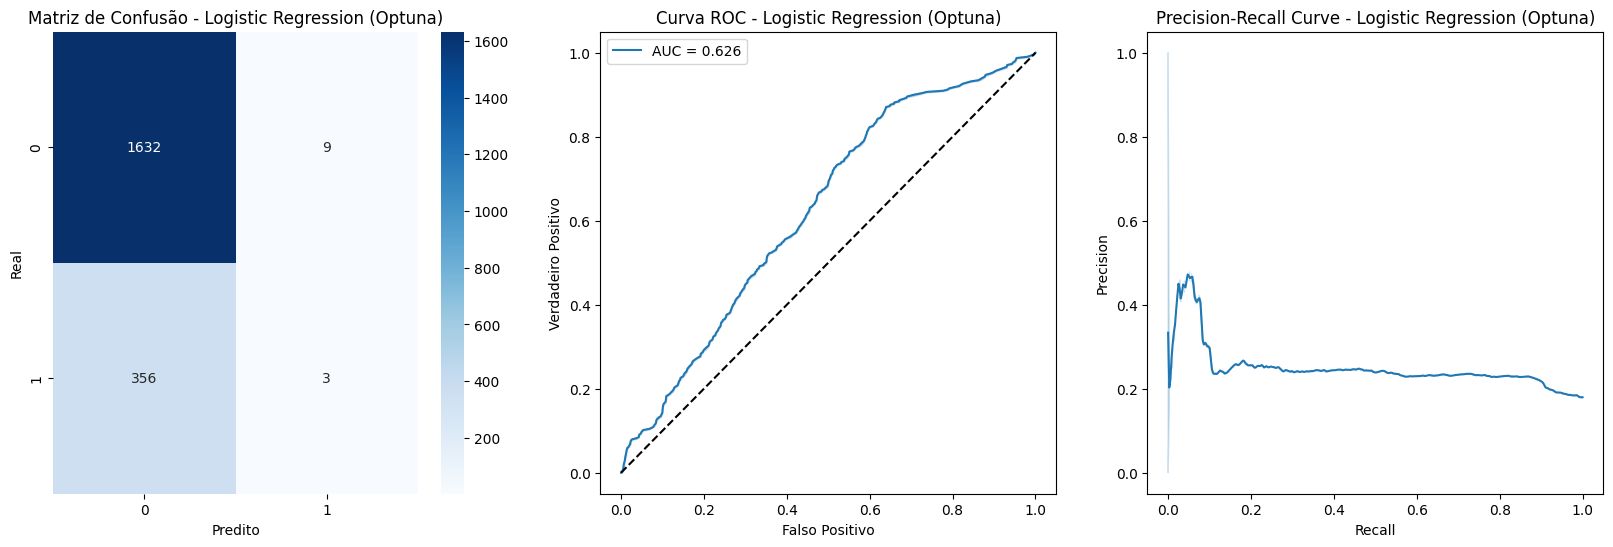

In [88]:
avaliar_modelo(best_lr_optuna, X_train_minmax, X_test_minmax, y_train, y_test, nome='Logistic Regression (Optuna)')

### Decision Tree Classifier

In [156]:
dt_model = DecisionTreeClassifier(random_state=42)


Decision Tree
              precision    recall  f1-score   support

         0.0      0.832     0.785     0.808      1641
         1.0      0.218     0.273     0.242       359

    accuracy                          0.694      2000
   macro avg      0.525     0.529     0.525      2000
weighted avg      0.721     0.694     0.706      2000



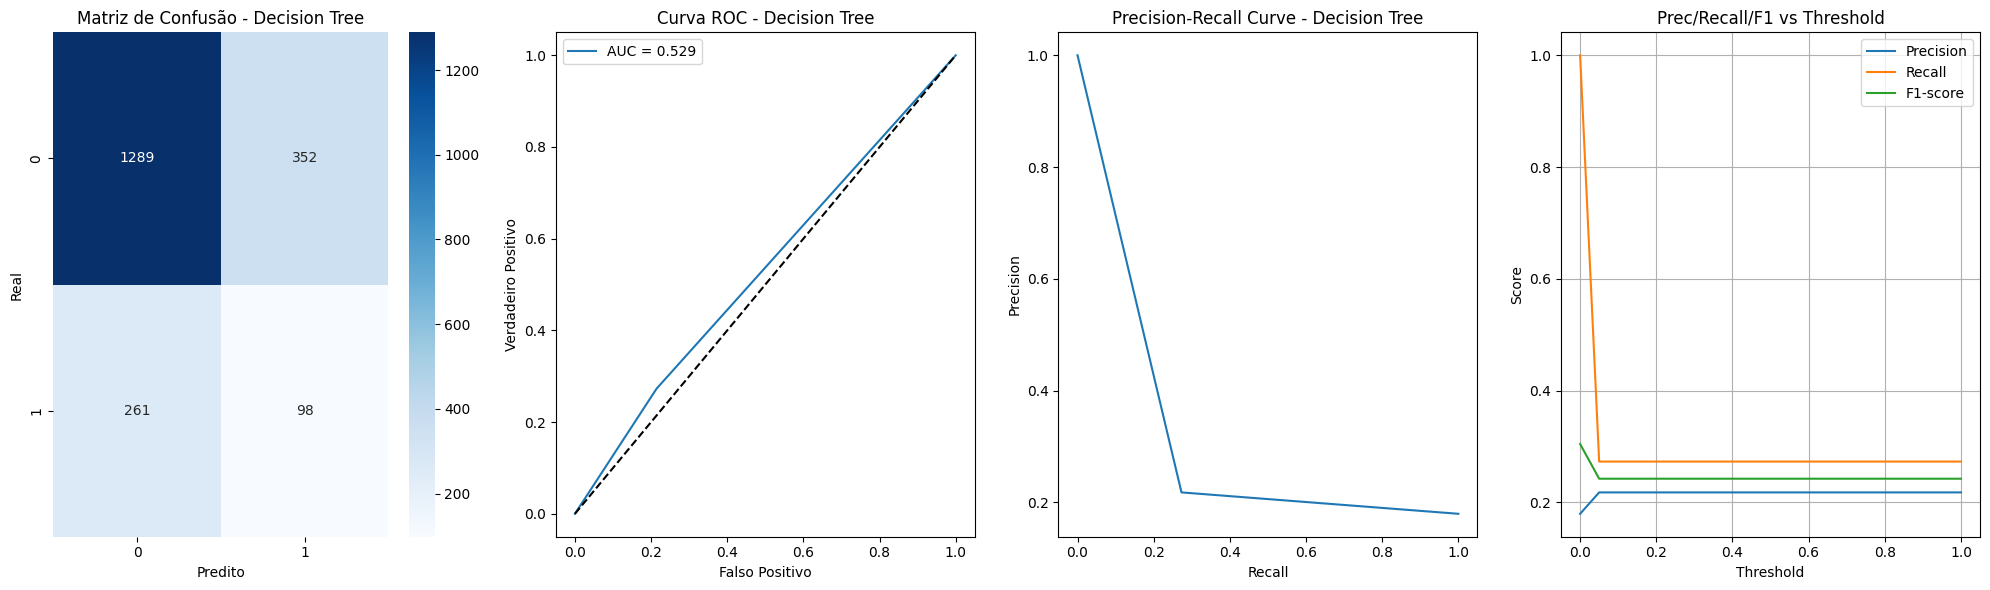

In [157]:
avaliar_modelo(dt_model, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Decision Tree')

#### Hiperparamtros

##### GridSearchCV
    Testa todas as combinações de parâmetros que você definir.

In [158]:
param_grid_dt = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train_minmax_over, y_train_over)
print("GridSearchCV DT:", grid_dt.best_params_)

GridSearchCV DT: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}



Decision Tree (Grid)
              precision    recall  f1-score   support

         0.0      0.831     0.916     0.872      1641
         1.0      0.281     0.150     0.196       359

    accuracy                          0.778      2000
   macro avg      0.556     0.533     0.534      2000
weighted avg      0.733     0.778     0.750      2000



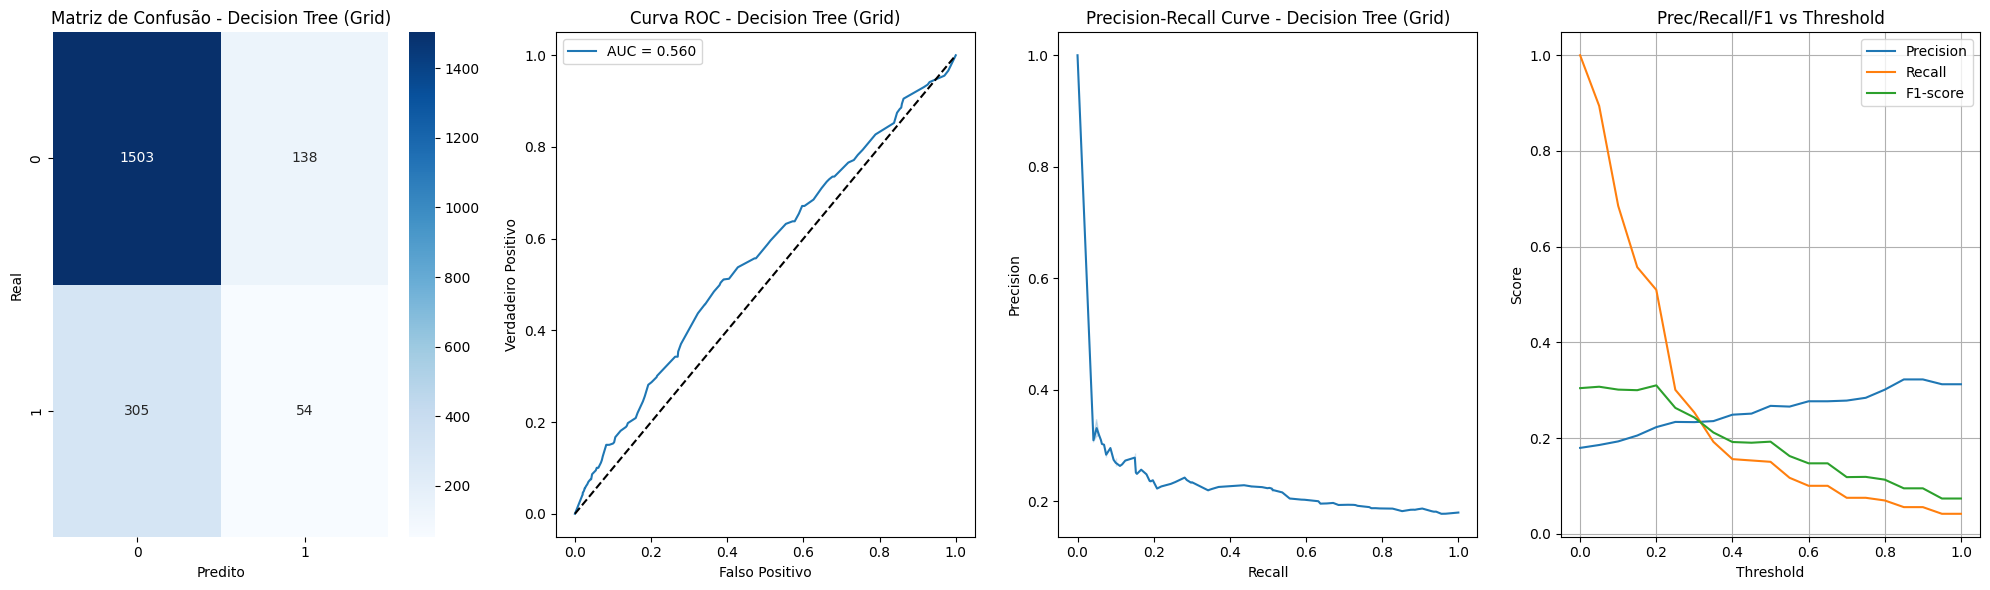

In [159]:
avaliar_modelo(grid_dt.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Decision Tree (Grid)')

##### RandomizedSearchCV
    Testa combinações aleatórias dos parâmetros (mais rápido quando tem muitas opções).

In [ ]:
param_dist_dt = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rnd_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dist_dt, cv=3, scoring='f1', n_jobs=-1)
rnd_dt.fit(X_train_minmax_over, y_train_over)
print("RandomizedSearchCV DT:", rnd_dt.best_params_)

RandomizedSearchCV DT: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


In [160]:
avaliar_modelo(rnd_dt.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Decision Tree (Randomized)')

NameError: name 'rnd_dt' is not defined

##### Otimização bayesiana
    A otimização bayesiana é uma técnica baseada no teorema de Bayes, que descreve a probabilidade de ocorrência de um evento relacionado ao conhecimento atual

In [ ]:
search_spaces_dt = {
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}
bayes_dt = BayesSearchCV(
    DecisionTreeClassifier(random_state=42),
    search_spaces=search_spaces_dt,
    n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42
)
bayes_dt.fit(X_train_minmax_over, y_train_over)
print("BayesSearchCV DT:", bayes_dt.best_params_)

BayesSearchCV DT: OrderedDict({'max_depth': 17, 'min_samples_leaf': 4, 'min_samples_split': 4})



Decision Tree (Bayes)
              precision    recall  f1-score   support

         0.0      0.821     0.862     0.841      1641
         1.0      0.183     0.142     0.160       359

    accuracy                          0.733      2000
   macro avg      0.502     0.502     0.501      2000
weighted avg      0.707     0.733     0.719      2000



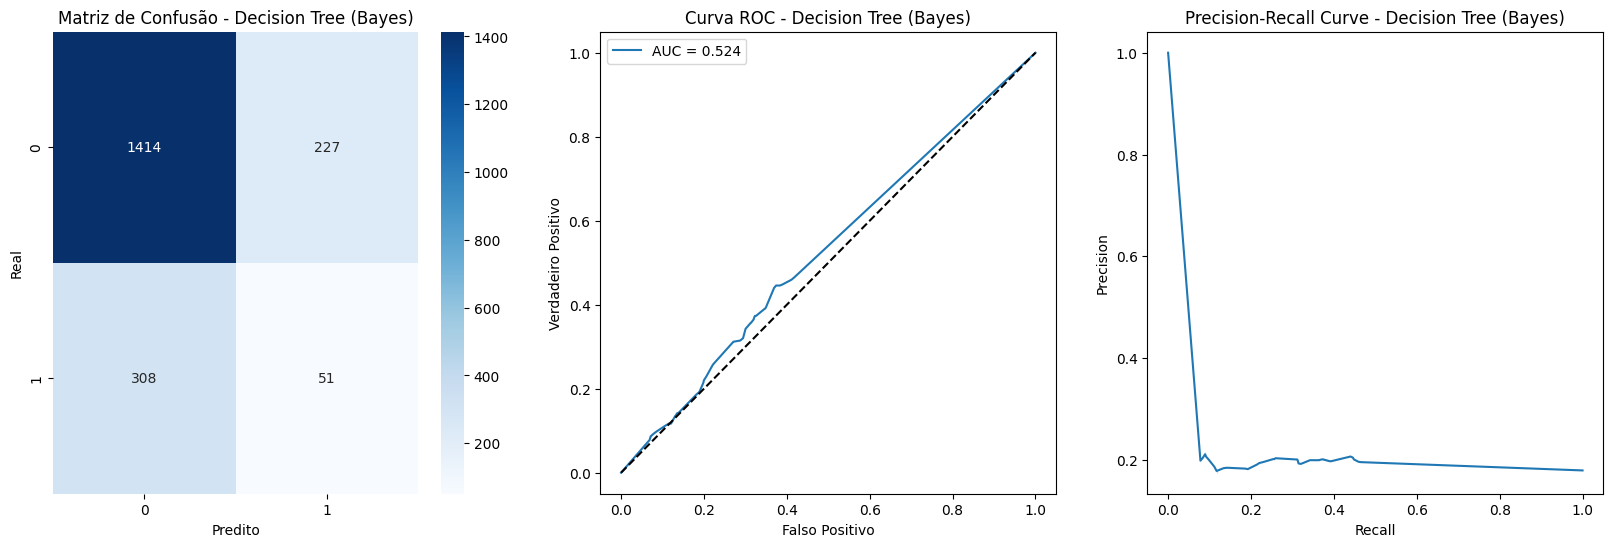

In [ ]:
avaliar_modelo(bayes_dt.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Decision Tree (Bayes)')

##### Optuna
    é um dos frameworks mais modernos para hyperparameter tuning, super flexível e fácil de usar.
    Ele funciona diferente: você define uma função de objetivo, e o Optuna faz os testes.

In [162]:
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    score = cross_val_score(model, X_train_minmax_over, y_train_over, cv=3, scoring='f1').mean()
    return score

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=10)
print("Optuna DT:", study_dt.best_params)
best_dt_optuna = DecisionTreeClassifier(**study_dt.best_params, random_state=42)
best_dt_optuna.fit(X_train_minmax_over, y_train_over)

[I 2025-07-16 21:21:56,210] A new study created in memory with name: no-name-fcd6c50c-7123-45e2-bc53-9a702419181f
[I 2025-07-16 21:21:56,698] Trial 0 finished with value: 0.7675446590339492 and parameters: {'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7675446590339492.
[I 2025-07-16 21:21:57,156] Trial 1 finished with value: 0.7631185821292138 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7675446590339492.
[I 2025-07-16 21:21:57,434] Trial 2 finished with value: 0.7209055313245143 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7675446590339492.
[I 2025-07-16 21:21:57,680] Trial 3 finished with value: 0.7181485897073587 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7675446590339492.
[I 2025-07-16 21:21:58,090] Trial 4 finished with value: 0.76814

Optuna DT: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2}


DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=9,
                       random_state=42)


Decision Tree (Optuna)
              precision    recall  f1-score   support

         0.0      0.828     0.884     0.855      1641
         1.0      0.234     0.162     0.191       359

    accuracy                          0.754      2000
   macro avg      0.531     0.523     0.523      2000
weighted avg      0.722     0.754     0.736      2000



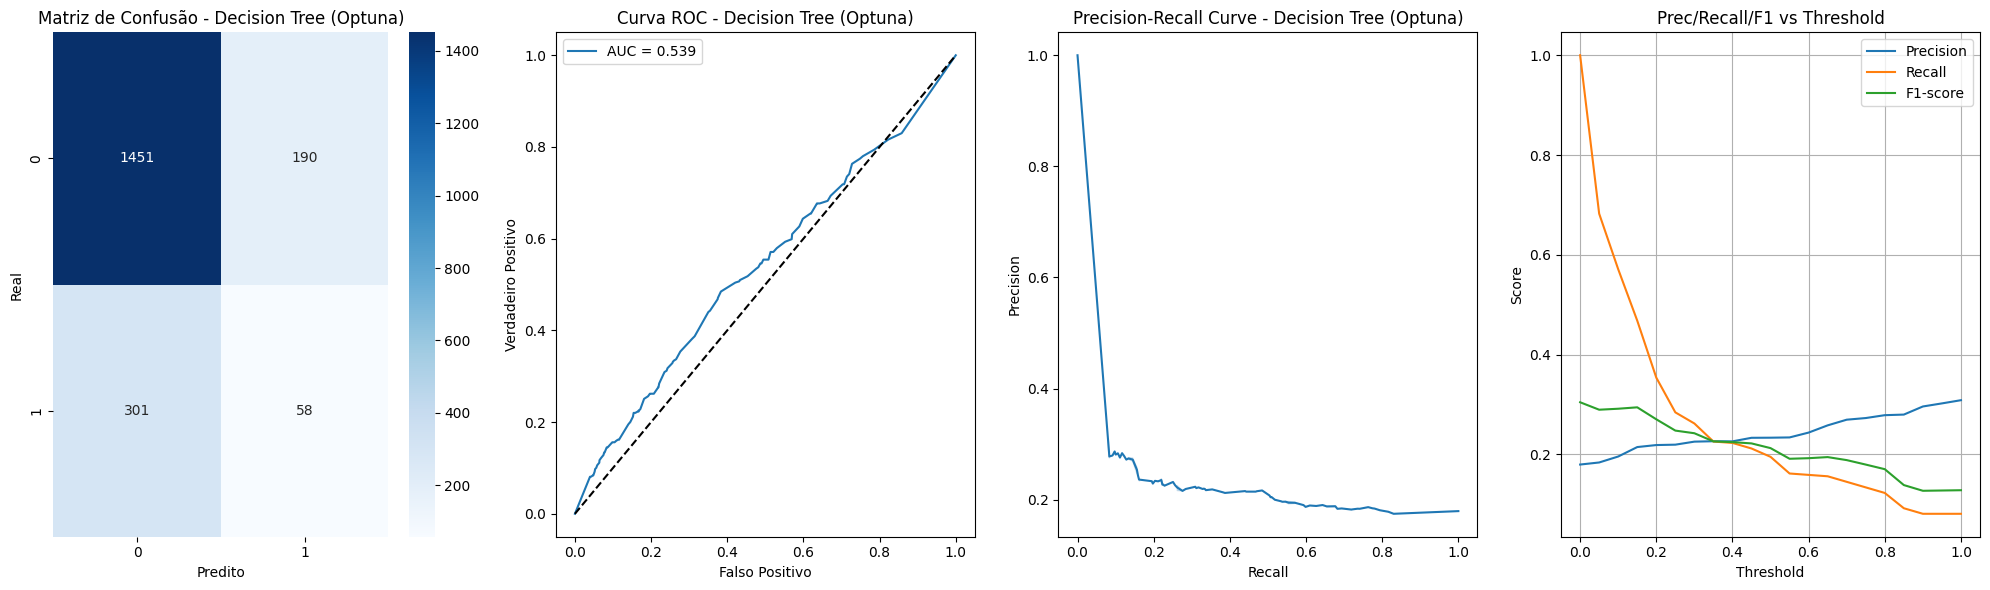

In [163]:
avaliar_modelo(best_dt_optuna, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='Decision Tree (Optuna)')

### K-Nearest Neighbors (KNN)

In [164]:
knn_model = KNeighborsClassifier(n_neighbors=5)


KNN
              precision    recall  f1-score   support

         0.0      0.840     0.511     0.635      1641
         1.0      0.199     0.554     0.292       359

    accuracy                          0.518      2000
   macro avg      0.519     0.532     0.464      2000
weighted avg      0.725     0.518     0.574      2000



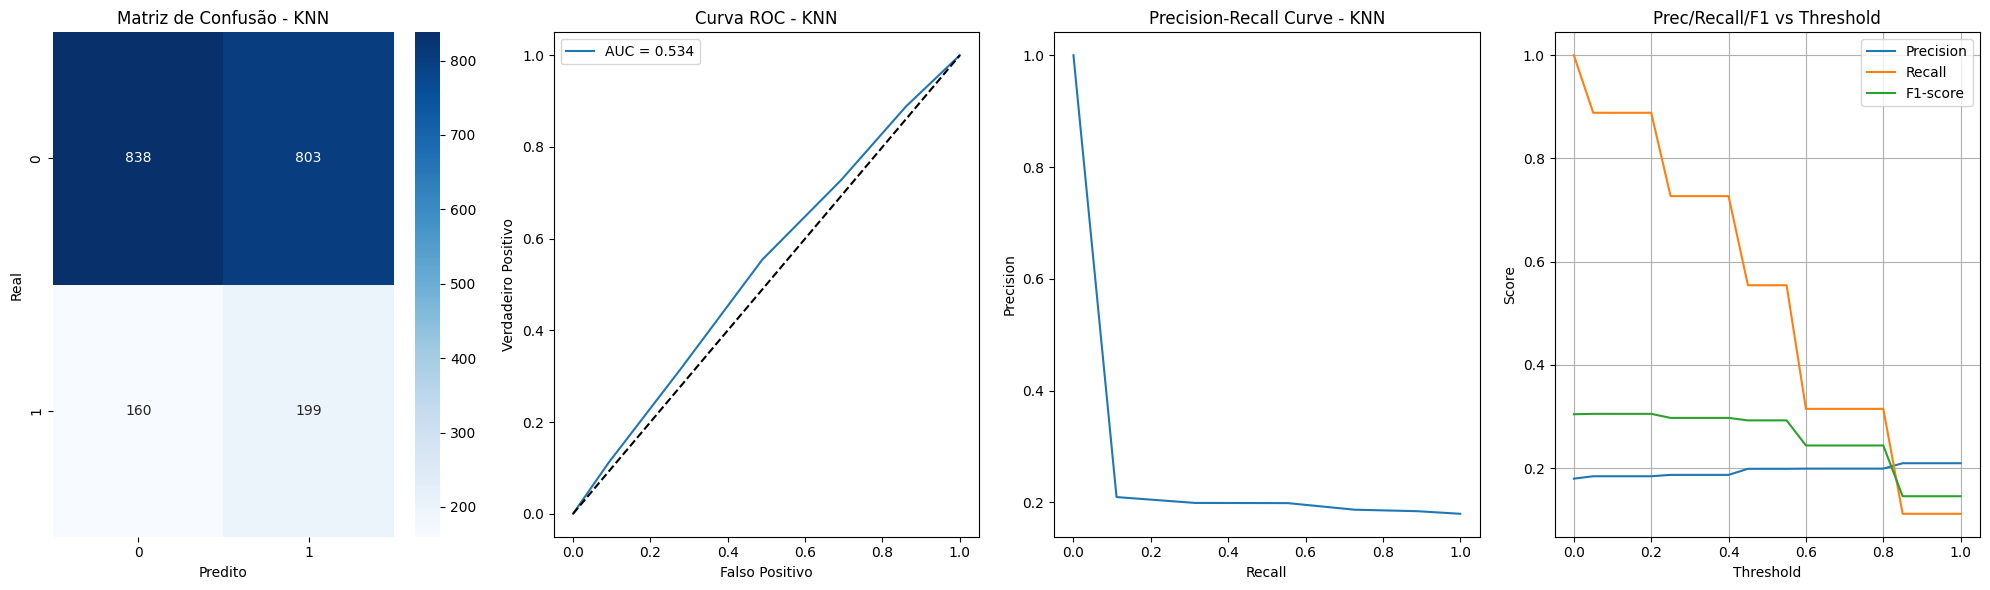

In [165]:
avaliar_modelo(knn_model, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='KNN')

#### Hiperparamtros

##### GridSearchCV
    Testa todas as combinações de parâmetros que você definir.

In [167]:
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] # 1=Manhattan, 2=Euclidiana
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train_minmax_over, y_train_over)
print("GridSearchCV KNN:", grid_knn.best_params_)

GridSearchCV KNN: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}



KNN (Grid)
              precision    recall  f1-score   support

         0.0      0.823     0.839     0.831      1641
         1.0      0.193     0.175     0.184       359

    accuracy                          0.720      2000
   macro avg      0.508     0.507     0.507      2000
weighted avg      0.710     0.720     0.715      2000



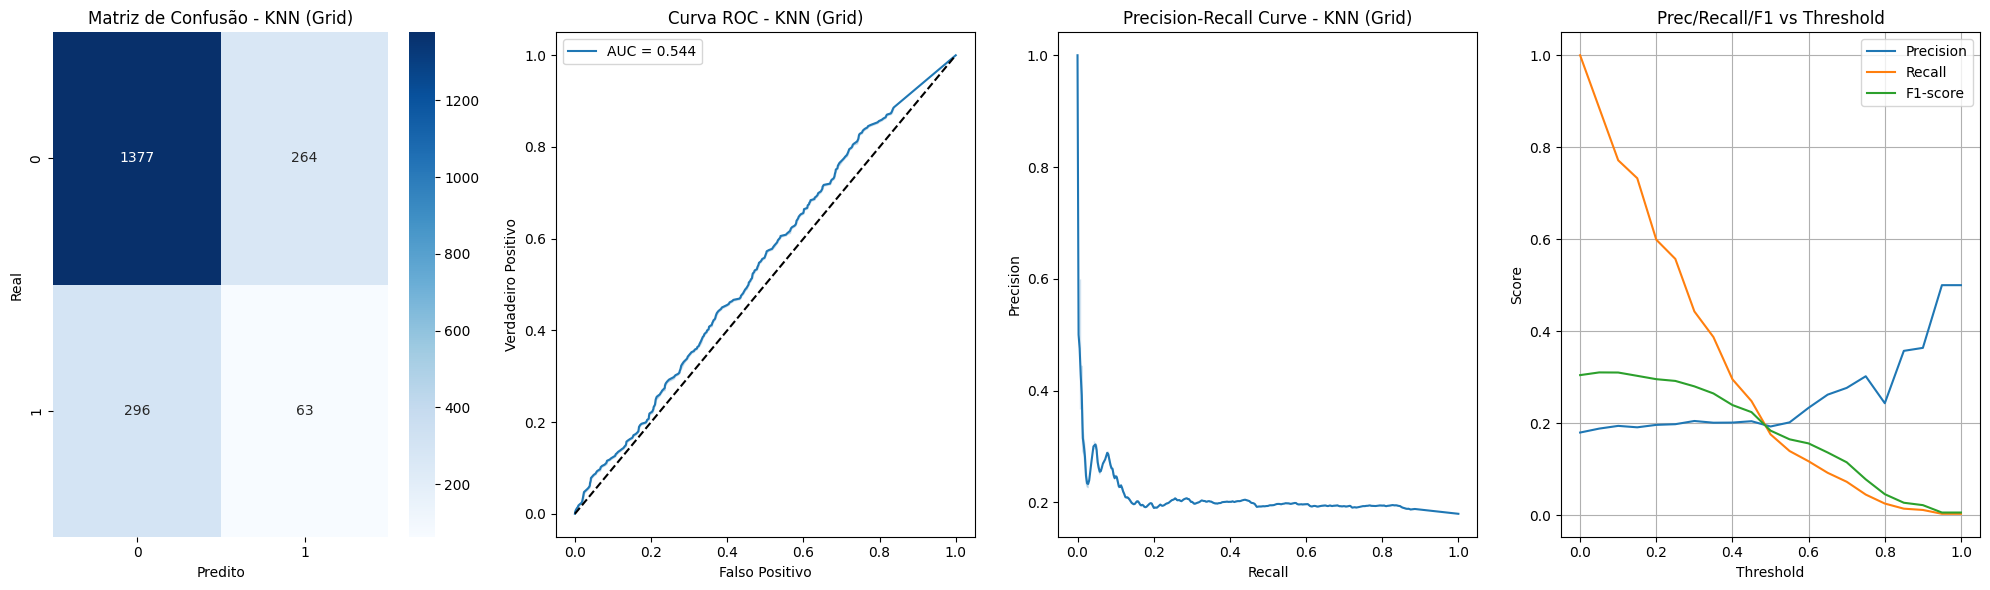

In [168]:
avaliar_modelo(grid_knn.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='KNN (Grid)')

##### RandomizedSearchCV
    Testa combinações aleatórias dos parâmetros (mais rápido quando tem muitas opções).

In [170]:
param_dist_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
rnd_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist_knn,
    n_iter=6, cv=3, scoring='f1', n_jobs=-1
)
rnd_knn.fit(X_train_minmax_over, y_train_over)
print("RandomizedSearchCV KNN:", rnd_knn.best_params_)

RandomizedSearchCV KNN: {'weights': 'distance', 'p': 1, 'n_neighbors': 5}



KNN (Random)
              precision    recall  f1-score   support

         0.0      0.821     0.809     0.815      1641
         1.0      0.182     0.195     0.188       359

    accuracy                          0.699      2000
   macro avg      0.502     0.502     0.502      2000
weighted avg      0.706     0.699     0.702      2000



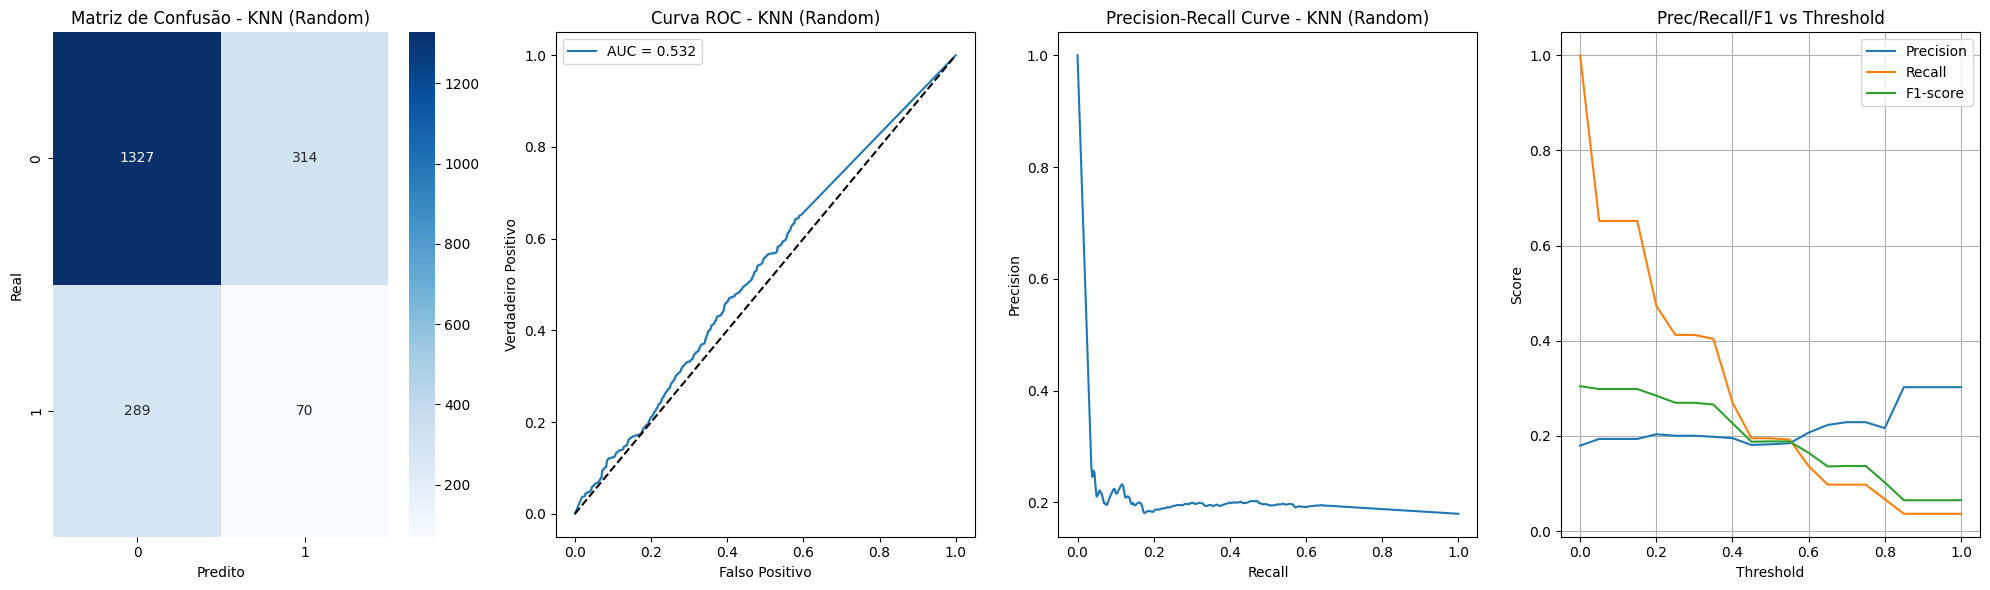

In [171]:
avaliar_modelo(rnd_knn.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='KNN (Random)')

##### Otimização bayesiana
    A otimização bayesiana é uma técnica baseada no teorema de Bayes, que descreve a probabilidade de ocorrência de um evento relacionado ao conhecimento atual

In [172]:
search_spaces_knn = {
    'n_neighbors': (3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
bayes_knn = BayesSearchCV(
    KNeighborsClassifier(),
    search_spaces=search_spaces_knn,
    n_iter=8, cv=3, scoring='f1', n_jobs=-1, random_state=42
)
bayes_knn.fit(X_train_minmax_over, y_train_over)
print("BayesSearchCV KNN:", bayes_knn.best_params_)


BayesSearchCV KNN: OrderedDict({'n_neighbors': 17, 'p': 1, 'weights': 'distance'})



KNN (Bayes)
              precision    recall  f1-score   support

         0.0      0.826     0.859     0.842      1641
         1.0      0.209     0.170     0.187       359

    accuracy                          0.736      2000
   macro avg      0.517     0.515     0.515      2000
weighted avg      0.715     0.736     0.725      2000



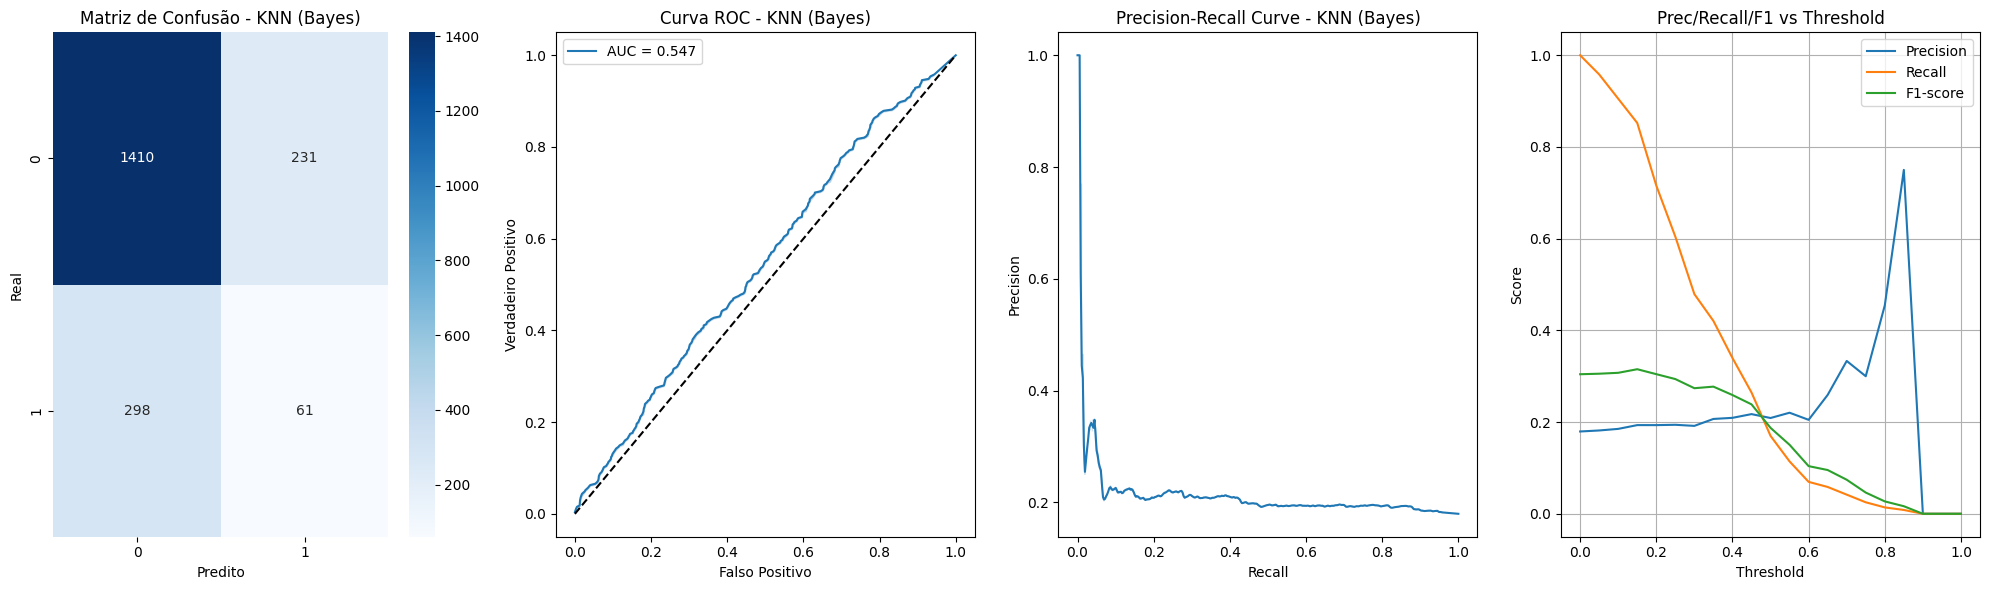

In [173]:
avaliar_modelo(bayes_knn.best_estimator_, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='KNN (Bayes)')

##### Optuna
    é um dos frameworks mais modernos para hyperparameter tuning, super flexível e fácil de usar.
    Ele funciona diferente: você define uma função de objetivo, e o Optuna faz os testes.

In [174]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )
    score = cross_val_score(model, X_train_minmax_over, y_train_over, cv=3, scoring='f1').mean()
    return score

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=8)
print("Optuna KNN:", study_knn.best_params)
best_knn_optuna = KNeighborsClassifier(**study_knn.best_params)
best_knn_optuna.fit(X_train_minmax_over, y_train_over)

[I 2025-07-16 21:23:44,689] A new study created in memory with name: no-name-df195e87-0b80-4a90-82ab-ea284976ae50
[I 2025-07-16 21:23:44,855] Trial 0 finished with value: 0.7320844258786346 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.7320844258786346.
[I 2025-07-16 21:23:45,002] Trial 1 finished with value: 0.7202747517458064 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.7320844258786346.
[I 2025-07-16 21:23:45,128] Trial 2 finished with value: 0.7524821572959167 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.7524821572959167.
[I 2025-07-16 21:23:45,668] Trial 3 finished with value: 0.8875788640610254 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.8875788640610254.
[I 2025-07-16 21:23:46,104] Trial 4 finished with value: 0.8296187624184331 and parameters: {'n_neighbors': 9, 'weight

Optuna KNN: {'n_neighbors': 16, 'weights': 'distance', 'p': 1}


KNeighborsClassifier(n_neighbors=16, p=1, weights='distance')


KNN (Optuna)
              precision    recall  f1-score   support

         0.0      0.827     0.862     0.844      1641
         1.0      0.217     0.175     0.194       359

    accuracy                          0.739      2000
   macro avg      0.522     0.519     0.519      2000
weighted avg      0.717     0.739     0.727      2000



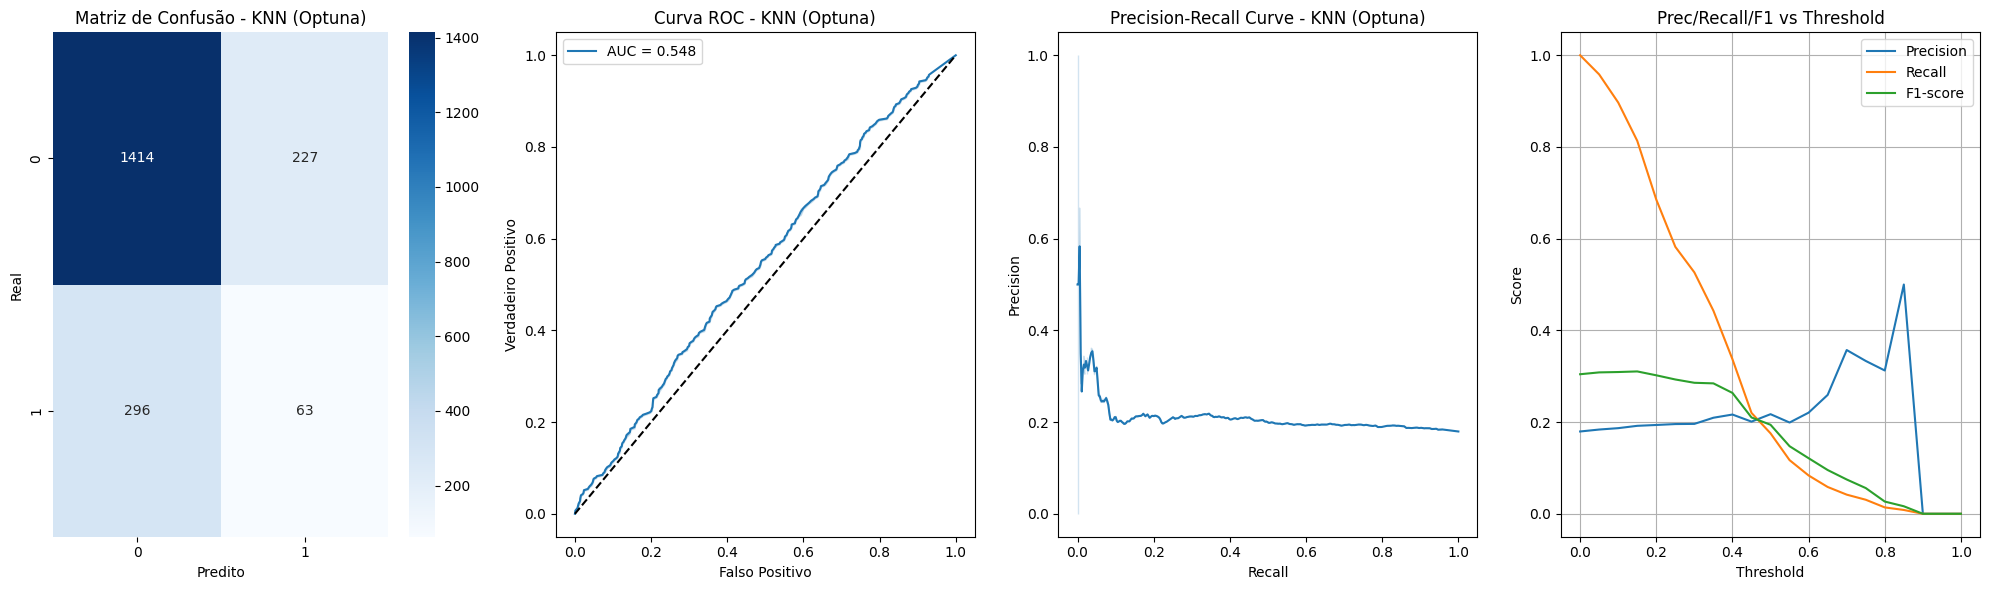

In [175]:
avaliar_modelo(best_knn_optuna, X_train_minmax_over, X_test_minmax_over, y_train_over, y_test, nome='KNN (Optuna)')

In [181]:
# Lista de variáveis dos modelos e principais objetos
model_vars = [
    'rf_model', 'rf_quick', 'xgb_model', 'dt_model', 'knn_model', 'lr_model',
    'grid', 'grid_xgb', 'grid_dt', 'grid_knn', 'grid_lr',
    'rnd', 'rnd_xgb', 'rnd_knn', 'random_lr',
    'opt', 'opt_xgb', 'bayes_lr', 'bayes_dt', 'bayes_knn',
    'study', 'study_xgb', 'study_lr', 'study_dt', 'study_knn',
    'best_rf', 'best_rf_rnd', 'best_rf_bayes', 'best_rf_optuna',
    'best_xgb_optuna', 'best_dt_optuna', 'best_knn_optuna', 'best_lr_optuna',
    'bayes_knn', 'bayes_dt', 'bayes_lr',
    'selector', 'one_hot_enc', 'scaler', 'smote', 'rus', 'explainer'
]

# Dicionário para armazenar os objetos
model_objects = {}

for var in model_vars:
    if var in globals():
        model_objects[var] = globals()[var]

In [182]:
# Diretório de salvamento
save_dir = 'data/pickle/teste'
os.makedirs(save_dir, exist_ok=True)

# Lista de modelos por algoritmo e tuning
model_dict = {
    'xgboost': [
        ('xgb_model', 'xgboost'),
        ('grid_xgb', 'xgboost_grid'),
        ('rnd_xgb', 'xgboost_random'),
        ('opt_xgb', 'xgboost_bayes'),
        ('best_xgb_optuna', 'xgboost_optuna')
    ],
    'random_forest': [
        ('rf_model', 'randomforest'),
        ('best_rf', 'randomforest_grid'),
        ('best_rf_rnd', 'randomforest_random'),
        ('best_rf_bayes', 'randomforest_bayes'),
        ('best_rf_optuna', 'randomforest_optuna')
    ],
    'knn': [
        ('knn_model', 'knn'),
        ('grid_knn', 'knn_grid'),
        ('rnd_knn', 'knn_random'),
        ('bayes_knn', 'knn_bayes'),
        ('best_knn_optuna', 'knn_optuna')
    ],
    'decision_tree': [
        ('dt_model', 'decisiontree'),
        ('grid_dt', 'decisiontree_grid'),
        ('rnd_dt', 'decisiontree_random'),
        ('bayes_dt', 'decisiontree_bayes'),
        ('best_dt_optuna', 'decisiontree_optuna')
    ],
    'logistic_regression': [
        ('lr_model', 'logreg'),
        ('grid_lr', 'logreg_grid'),
        ('random_lr', 'logreg_random'),
        ('bayes_lr', 'logreg_bayes'),
        ('best_lr_optuna', 'logreg_optuna')
    ]
}

# Salvar cada modelo se existir no model_objects
for alg, models in model_dict.items():
    for var_name, file_name in models:
        if var_name in model_objects:
            with open(os.path.join(save_dir, f'{file_name}.pkl'), 'wb') as f:
                pickle.dump(model_objects[var_name], f)

### Comparando varios de uma vez

In [ ]:
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
param_lr = {
    'C': (0.001, 10.0, 'log-uniform'),
    'solver': ['lbfgs', 'liblinear']
}
param_dt = {
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}
param_knn = {
    'n_neighbors': (3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
param_xgb = {
    'n_estimators': (100, 300),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.8, 1.0)
}

models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_rf),
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), param_lr),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), param_dt),
    'KNN': (KNeighborsClassifier(), param_knn),
    'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_xgb),
}

resultados = []
for nome, (model, param_grid) in models.items():
    for search_type in [ 'random', 'bayes', 'optuna']:
        print(f'Rodando {nome} - {search_type}')
        best_model, best_params, best_score = tune_model(model, search_type, param_grid, X_train_minmax, y_train_over, n_iter=10)
        avaliar_modelo(best_model, X_train_minmax, X_test_minmax, y_train_over, y_test, nome=f'{nome}_{search_type}')
        y_pred = best_model.predict(X_test_minmax)
        acc = accuracy_score(y_test, y_pred)
        resultados.append({
            'modelo': nome,
            'search': search_type,
            'score_cv_f1': best_score,
            'score_acc': acc,
            'params': best_params
        })


Rodando Random Forest - random


KeyboardInterrupt: 

In [119]:
resultados

[{'modelo': 'Random Forest',
  'search': 'grid',
  'score_cv_f1': np.float64(0.010938279647878515),
  'score_acc': 0.8215,
  'params': {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}},
 {'modelo': 'Random Forest',
  'search': 'random',
  'score_cv_f1': np.float64(0.008217067145638574),
  'score_acc': 0.82,
  'params': {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}},
 {'modelo': 'Random Forest',
  'search': 'bayes',
  'score_cv_f1': np.float64(0.0068619823221050215),
  'score_acc': 0.8205,
  'params': OrderedDict([('max_depth', 20),
               ('min_samples_split', 2),
               ('n_estimators', 160)])},
 {'modelo': 'Random Forest',
  'search': 'optuna',
  'score_cv_f1': np.float64(0.008217067145638574),
  'score_acc': 0.82,
  'params': {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}},
 {'modelo': 'Logistic Regression',
  'search': 'grid',
  'score_cv_f1': np.float64(0.037272291165914434),
  'score_acc': 0.8175,
  'params': {'C': 10

                 modelo  search  score_cv_f1  score_acc  \
0         Random Forest    grid     0.010938     0.8215   
1         Random Forest  random     0.008217     0.8200   
2         Random Forest   bayes     0.006862     0.8205   
3         Random Forest  optuna     0.008217     0.8200   
4   Logistic Regression    grid     0.037272     0.8175   
5   Logistic Regression  random     0.037272     0.8175   
6   Logistic Regression   bayes     0.034616     0.8180   
7   Logistic Regression  optuna     0.034616     0.8180   
8         Decision Tree    grid     0.230327     0.7375   
9         Decision Tree  random     0.230327     0.7375   
10        Decision Tree   bayes     0.227445     0.7325   
11        Decision Tree  optuna     0.215346     0.7250   
12                  KNN    grid     0.130692     0.7730   
13                  KNN  random     0.130692     0.7730   
14                  KNN   bayes     0.125240     0.7785   
15                  KNN  optuna     0.054102     0.8095 

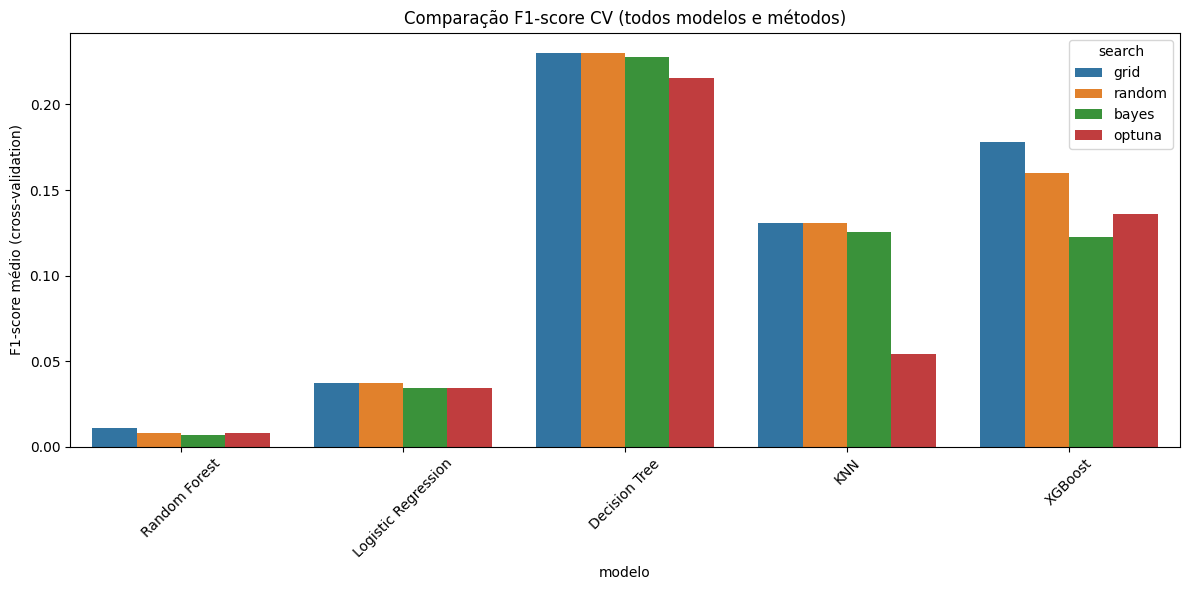

In [120]:
import pandas as pd
df_result = pd.DataFrame(resultados)
print(df_result)

# Gráfico comparando os scores
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=df_result, x='modelo', y='score_cv_f1', hue='search')
plt.title('Comparação F1-score CV (todos modelos e métodos)')
plt.ylabel('F1-score médio (cross-validation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


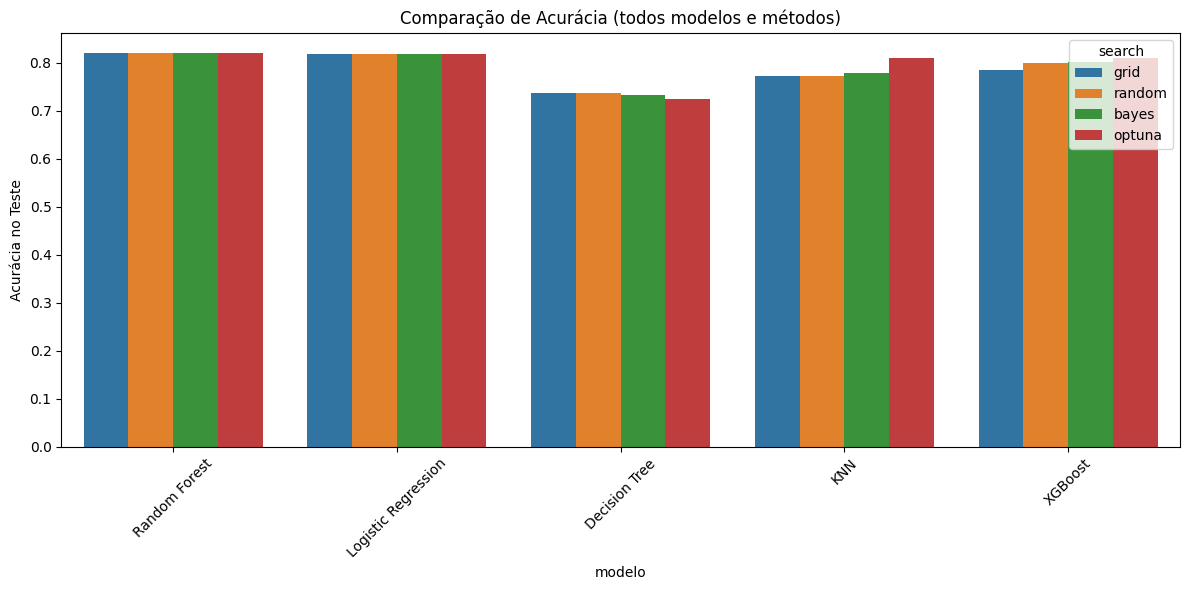

In [121]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_result, x='modelo', y='score_acc', hue='search')
plt.title('Comparação de Acurácia (todos modelos e métodos)')
plt.ylabel('Acurácia no Teste')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## HiperParametros e Tunnings
    Hiperparâmetros são atributos que controlam o treinamento do modelo de machine learning: com eles podemos tornar o modelo mais preparado para resolver um determinado problema da vida real. Fazendo a comparação com um carro, podemos associar os  parâmetros com o motor e a gasolina e os hiperparâmetros são como a direção, o sensor de velocidade e retrovisores. O carro funciona somente com motor e gasolina. Contudo, sem os outros equipamentos, podemos levar o veículo a um desastre porque não teríamos o controle dele.
[Fonte](https://blog.dsbrigade.com/hiperparametros-por-que-sao-importantes/)

### Random forest
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features

In [85]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### XGBoost/LightGBM/CatBoost
    n_estimators, max_depth, learning_rate, subsample, colsample_bytree

### KNN
    n_neighbors, weights, p

### Decision Tree
    max_depth, min_samples_split, min_samples_leaf

### Logistic Regression
    C (regularização), penalty